# Proyek Akhir: Menyelesaikan Permasalahan Institusi Pendidikan

- Nama: Danang Agung Restu Aji
- Email: danangrestuaji@gmail.com
- Id Dicoding: profdara

**tujuan dari proyek ini adalah :**
- Menggunakan analisis data guna mengidentifikasi pola dan faktor yang berkontribusi terhadap kemungkinan dropout siswa.
- Membangun model prediksi berdasarkan dataset students' performance untuk memprediksi siswa yang berisiko tinggi mengalami dropout.
- Mengembangkan dashboard visualisasi yang dapat membantu pihak institut dalam memahami tren data dan melakukan intervensi yang tepat untuk mencegah dropout.

## Persiapan

### Menyiapkan library yang dibutuhkan

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import joblib
import os
import os
import warnings
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")  # Hindari warning yang mengganggu

## Data Understanding

In [2]:
# Visualisasi default
sns.set(style="whitegrid", palette="pastel")
plt.rcParams.update({"figure.figsize": (12, 6), "axes.titlesize": 14})

# Load dataset dengan separator ";"
file_path = "data.csv"
if os.path.exists(file_path):
    df = pd.read_csv(file_path, sep=";")
    print("Data berhasil dimuat!")
else:
    raise FileNotFoundError(f"File tidak ditemukan di path: {file_path}")

# Cek info awal
df.info()
df.describe(include="all")
df.head()


Data berhasil dimuat!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                    

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
# cek duplikat
df.duplicated().sum()

np.int64(0)

tidak ada duplikat

In [4]:
df.Status.value_counts()

Status
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

ada 3 status yang ada pada kolom status, yaitu
- Graduate = Lulus
- Dropout = Mengundurkan Diri
- Enrolled = Teraftar

Dari data ini, terlihat bahwa sebanyak **1.421 siswa mengalami dropout** (32% dari total siswa), yang merupakan perhatian utama bagi Jaya Jaya Institut. Dengan analisis yang lebih mendalam, kita dapat mengidentifikasi faktor-faktor yang berkontribusi terhadap dropout dan mengambil tindakan pencegahan yang lebih efektif.

In [5]:
df.isna().sum()

Marital_status                                  0
Application_mode                                0
Application_order                               0
Course                                          0
Daytime_evening_attendance                      0
Previous_qualification                          0
Previous_qualification_grade                    0
Nacionality                                     0
Mothers_qualification                           0
Fathers_qualification                           0
Mothers_occupation                              0
Fathers_occupation                              0
Admission_grade                                 0
Displaced                                       0
Educational_special_needs                       0
Debtor                                          0
Tuition_fees_up_to_date                         0
Gender                                          0
Scholarship_holder                              0
Age_at_enrollment                               0


Dari hasil df.isna(), terlihat bahwa tidak ada missing values dalam dataset kamu—setiap kolom memiliki nilai yang lengkap. Ini berarti kamu tidak perlu menangani data yang hilang dengan metode seperti imputasi atau penghapusan baris.


In [6]:

def detect_outliers(df):
  outlier_indices = {}
  for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
    if outliers:
      outlier_indices[col] = outliers
  return outlier_indices

# Gunakan fungsi untuk mendeteksi outlier
outliers_dict = detect_outliers(df)

# Cetak hasil deteksi outlier
if outliers_dict:
  print("Outliers found:")
  for col, indices in outliers_dict.items():
    print(f"  Column '{col}': {len(indices)} outliers at indices {indices}")
else:
  print("No outliers found in numerical columns.")


Outliers found:
  Column 'Marital_status': 505 outliers at indices [4, 5, 38, 56, 65, 79, 84, 93, 94, 102, 103, 166, 221, 225, 226, 255, 277, 281, 282, 285, 295, 342, 347, 348, 353, 370, 371, 373, 374, 375, 380, 409, 428, 439, 455, 458, 511, 514, 515, 516, 518, 575, 578, 597, 611, 640, 647, 678, 683, 684, 685, 688, 689, 690, 691, 694, 696, 701, 703, 705, 706, 707, 708, 710, 712, 714, 717, 718, 725, 733, 734, 745, 753, 759, 762, 764, 768, 833, 834, 846, 853, 871, 895, 912, 913, 916, 917, 918, 919, 920, 924, 927, 932, 933, 939, 942, 948, 951, 966, 968, 971, 972, 973, 974, 977, 981, 983, 994, 1042, 1129, 1161, 1163, 1166, 1178, 1180, 1186, 1194, 1201, 1202, 1207, 1209, 1212, 1222, 1223, 1241, 1244, 1245, 1255, 1263, 1272, 1273, 1277, 1294, 1295, 1398, 1428, 1437, 1467, 1478, 1481, 1490, 1498, 1502, 1503, 1511, 1521, 1530, 1532, 1535, 1539, 1541, 1542, 1547, 1548, 1549, 1550, 1570, 1572, 1573, 1574, 1576, 1614, 1615, 1622, 1623, 1630, 1631, 1632, 1634, 1636, 1677, 1717, 1725, 1729, 1732, 1

In [7]:
# Pastikan daftar kolom numerik terdefinisi
num = df.select_dtypes(include=np.number).columns

# Menyimpan hasil outlier summary outlier
outlier = []

for col in num:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    outlier_mask = ~df[col].between(low, high)
    outlier.append({
        "Kolom": col,
        "Status Outlier": outlier_mask.any(),
        "Jumlah": outlier_mask.sum(),
        "Batas Bawah": low,
        "Batas Atas": high,


    })

# Menghitung jumlah total outlier dalam dataset
combined_outlier_mask = np.all([
    df[col].between(df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)),
                    df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))
    for col in num
], axis=0)

print(f'Jumlah total baris: {len(df)}')
print("Jumlah Outlier pada Seluruh Data :", (~combined_outlier_mask).sum())
print("Jumlah Data yang Bukan Outlier :", combined_outlier_mask.sum())

# Simpan hasil analisis dalam DataFrame
outlier_summary_df = pd.DataFrame(outlier)
print(outlier_summary_df)




Jumlah total baris: 4424
Jumlah Outlier pada Seluruh Data : 3519
Jumlah Data yang Bukan Outlier : 905
                                           Kolom  Status Outlier  Jumlah  \
0                                 Marital_status            True     505   
1                               Application_mode           False       0   
2                              Application_order            True     541   
3                                         Course            True     442   
4                     Daytime_evening_attendance            True     483   
5                         Previous_qualification            True     707   
6                   Previous_qualification_grade            True     179   
7                                    Nacionality            True     110   
8                          Mothers_qualification           False       0   
9                          Fathers_qualification           False       0   
10                            Mothers_occupation            Tr

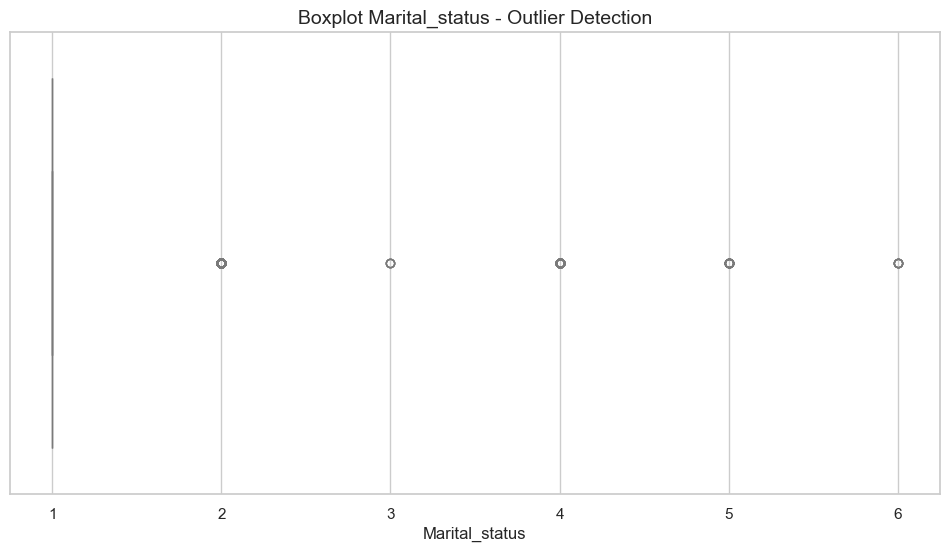

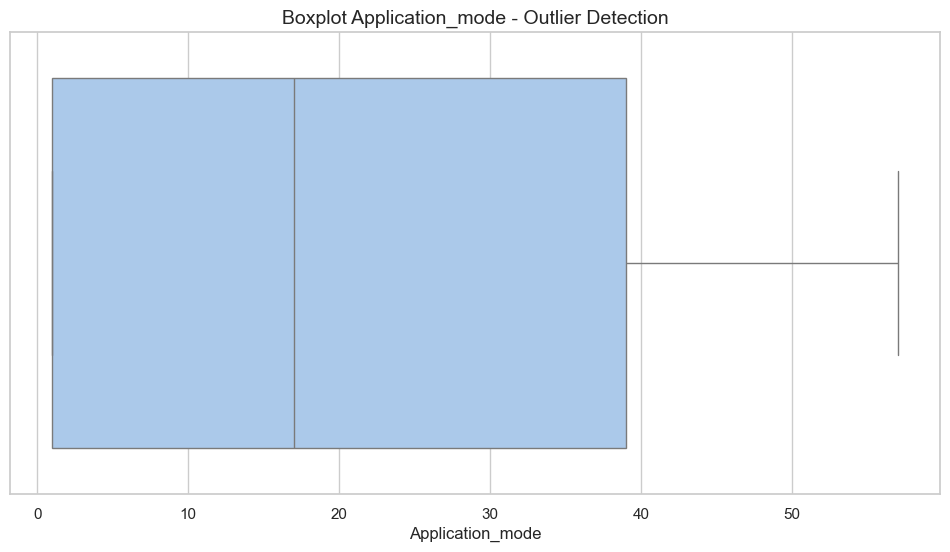

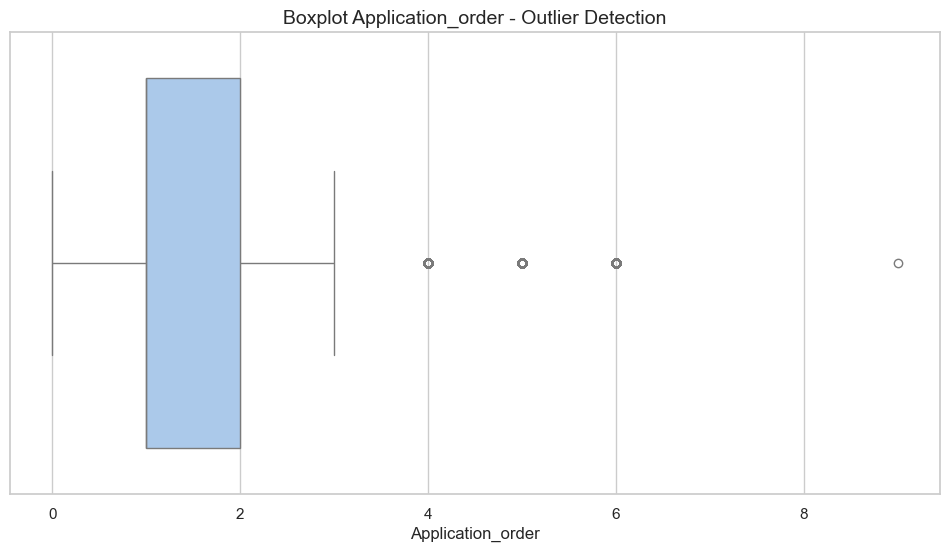

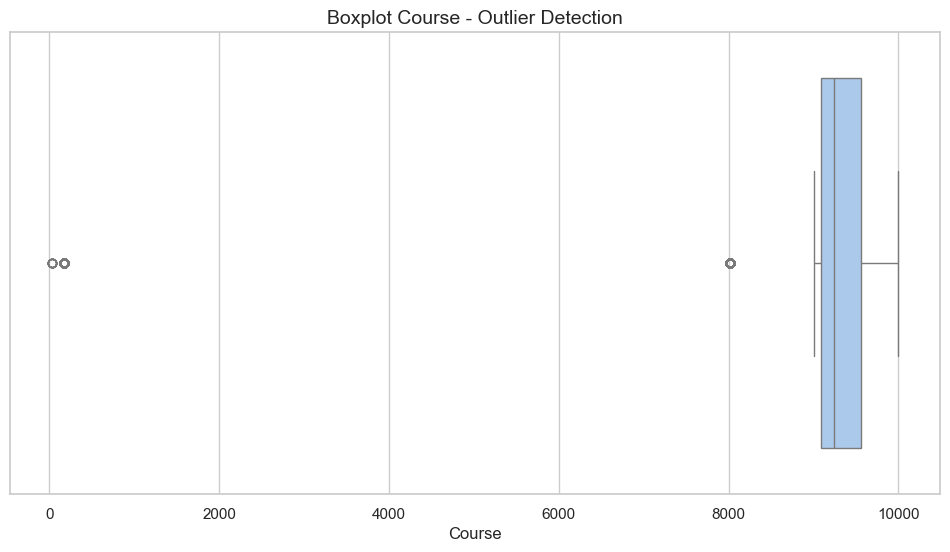

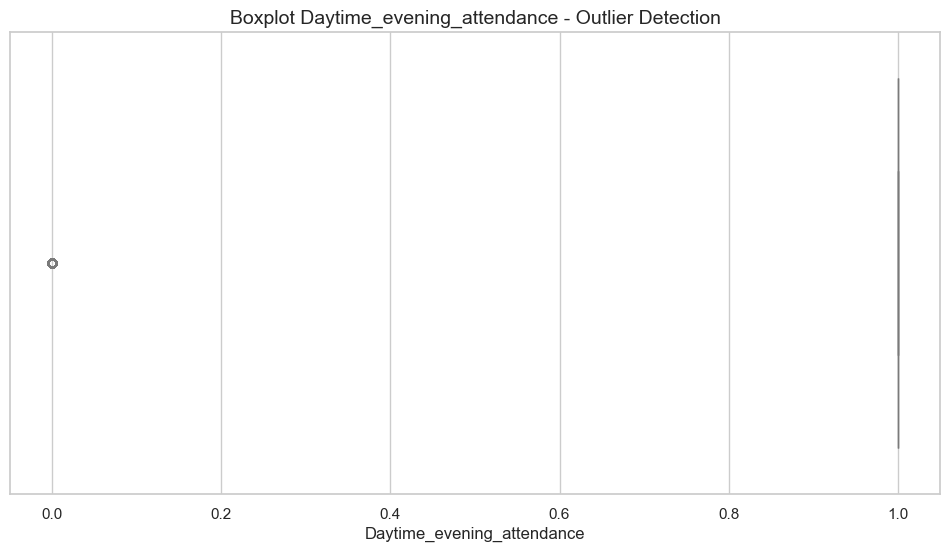

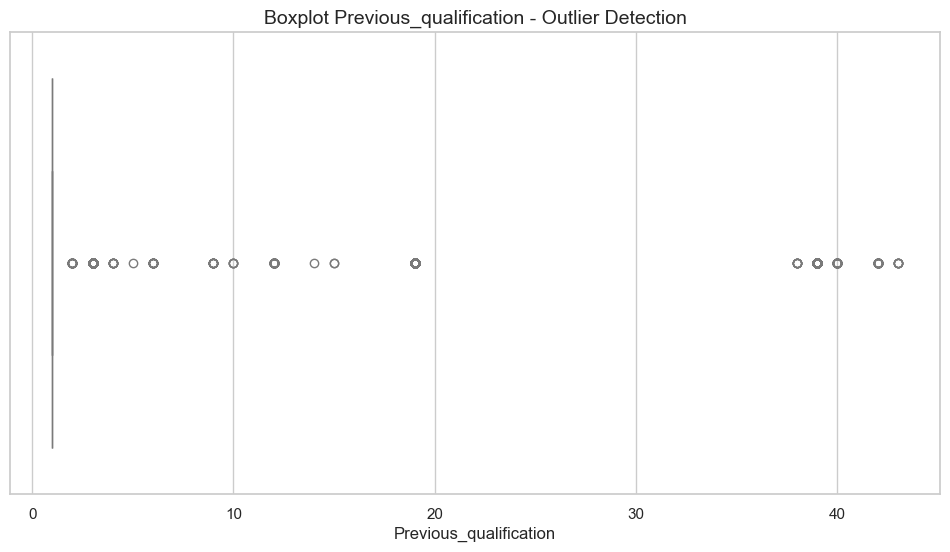

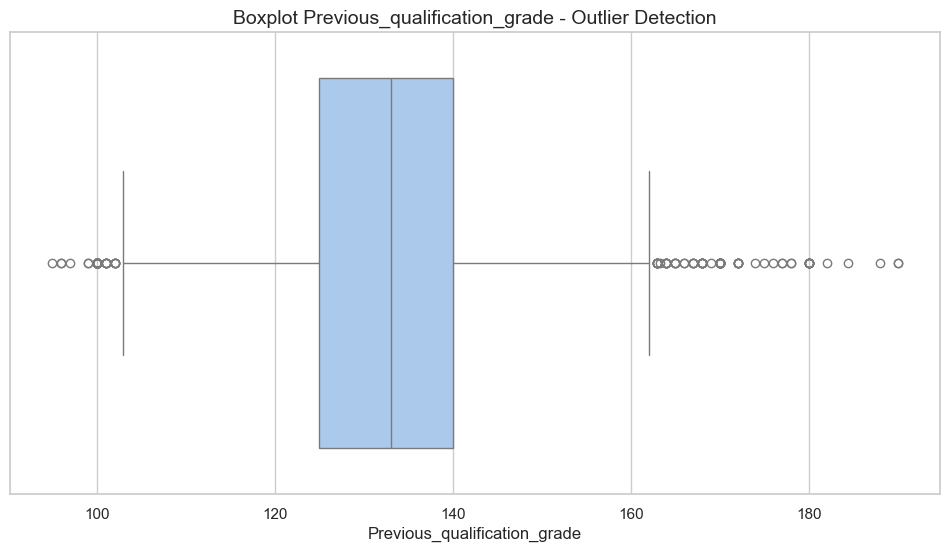

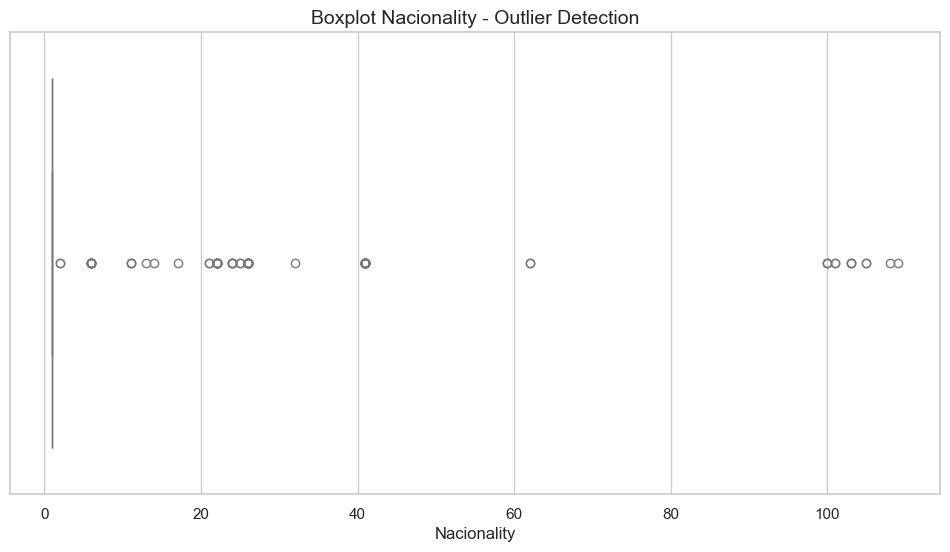

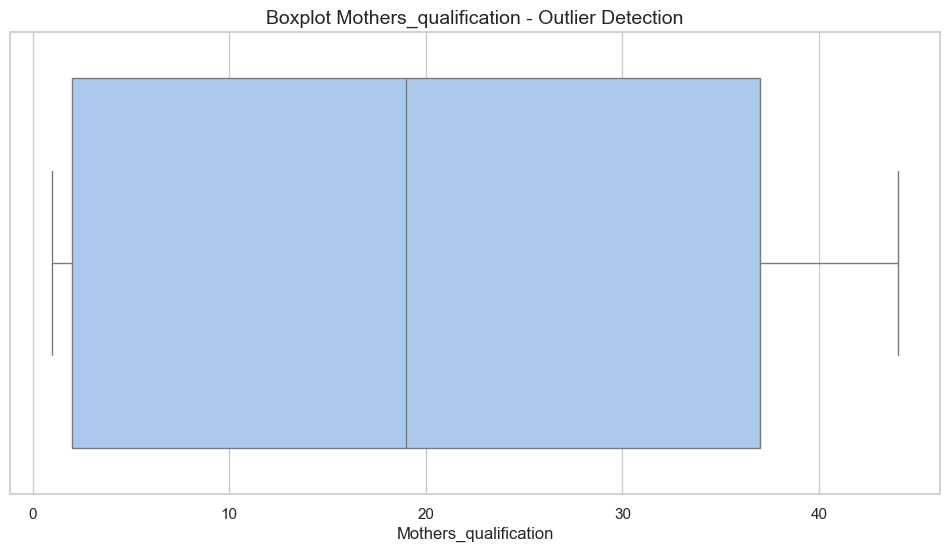

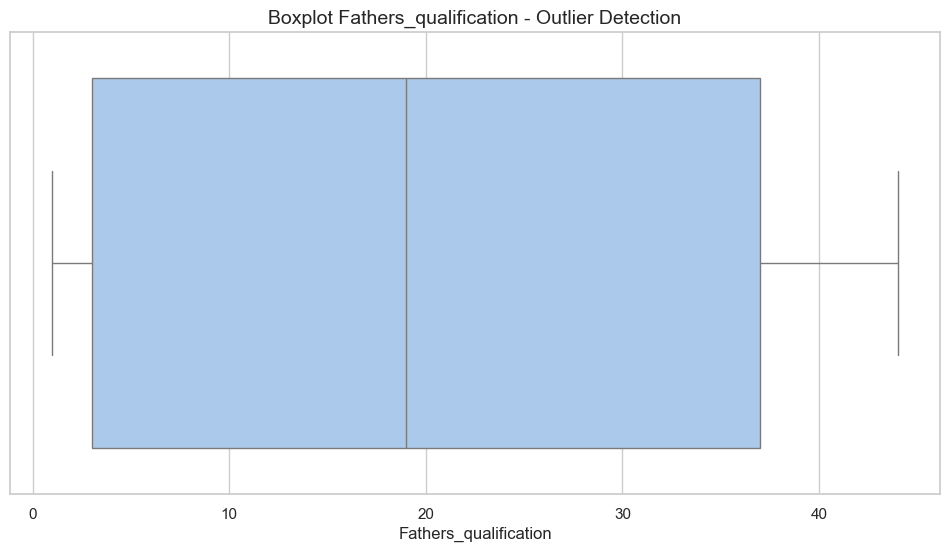

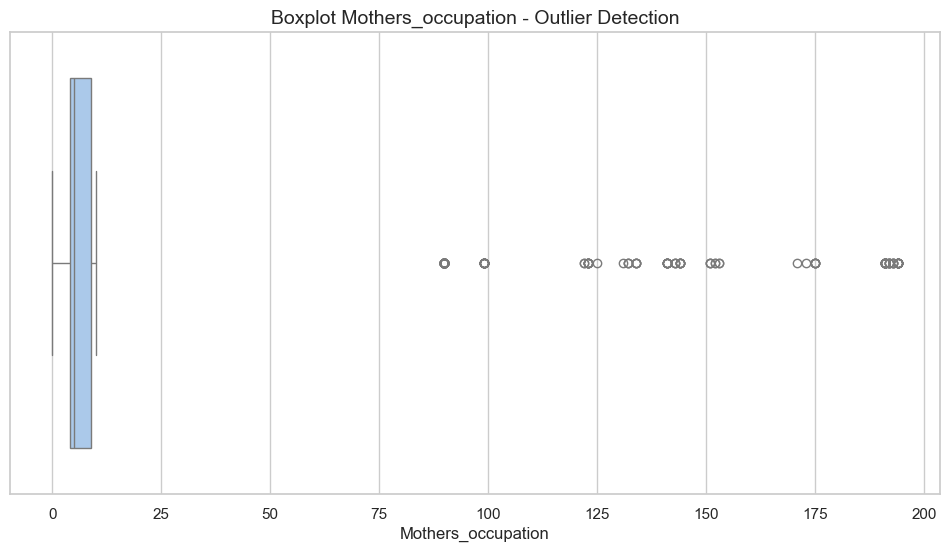

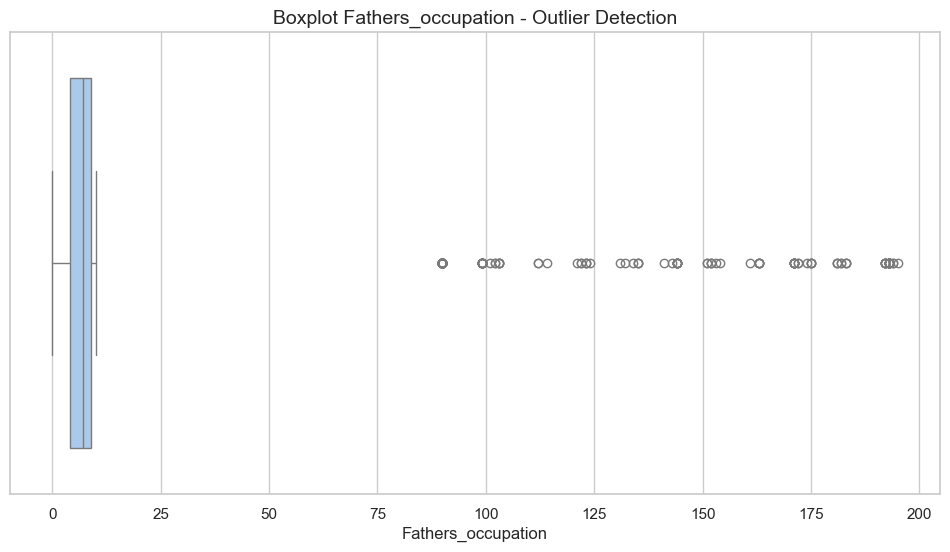

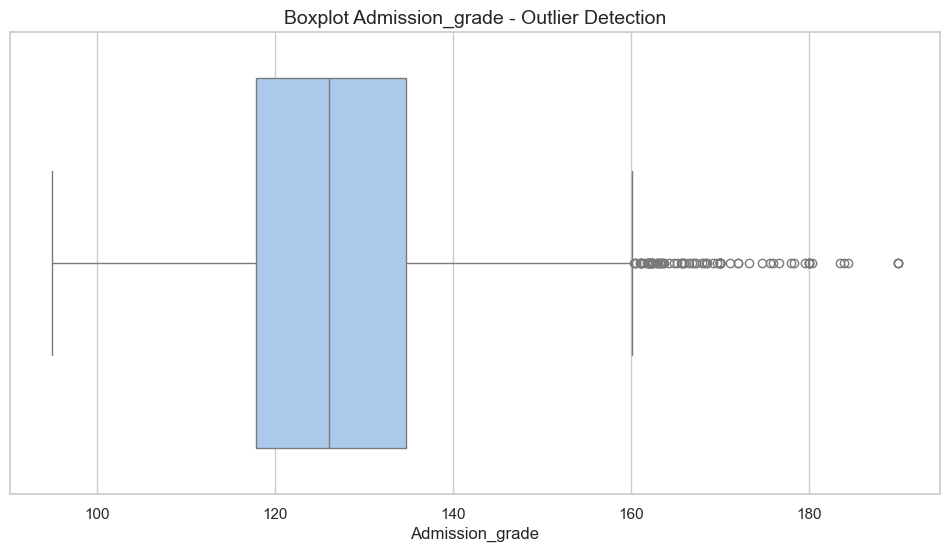

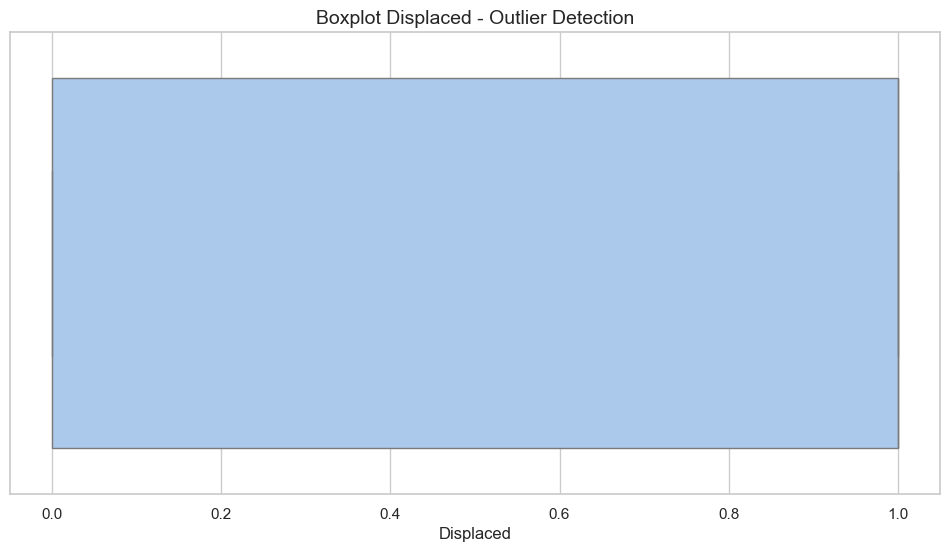

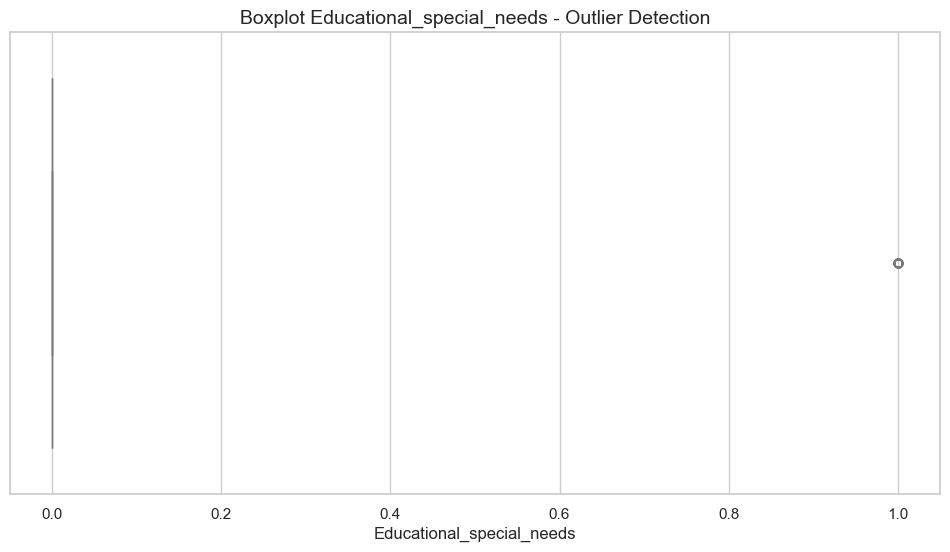

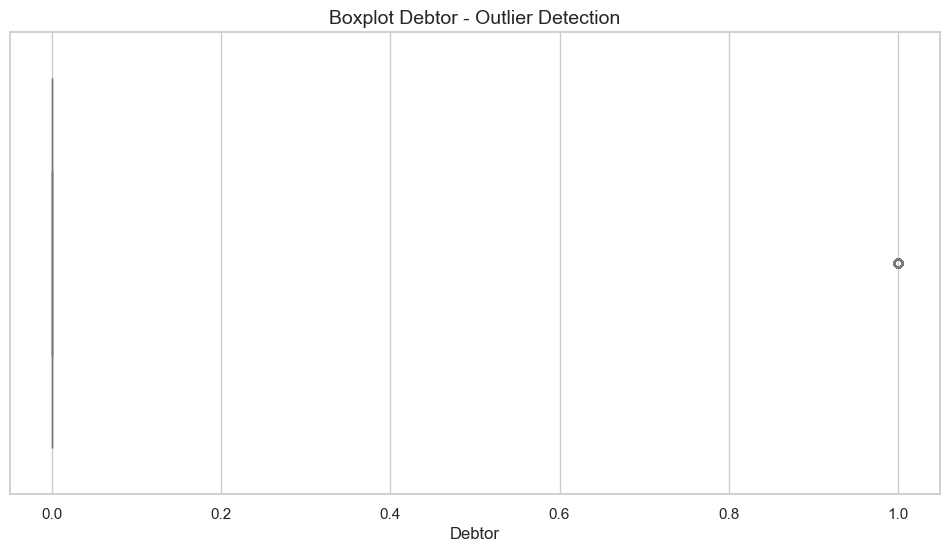

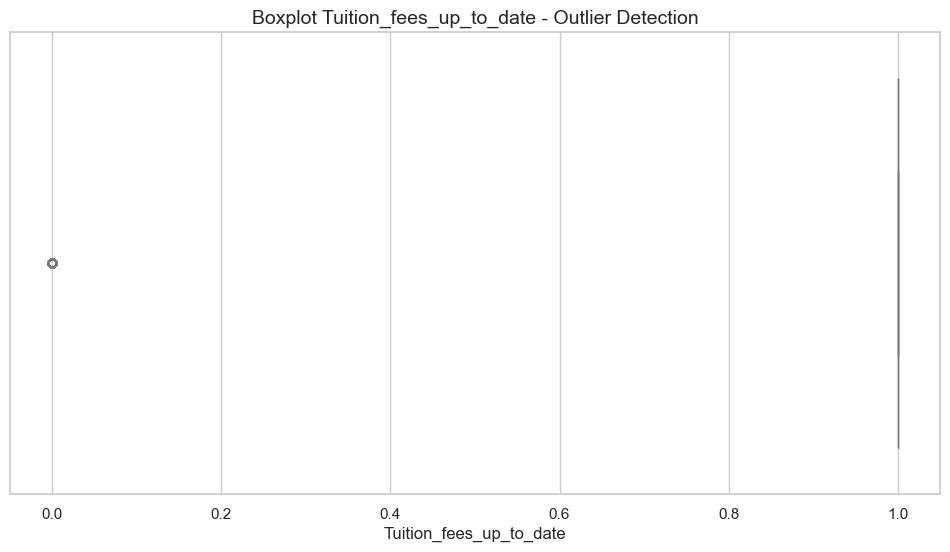

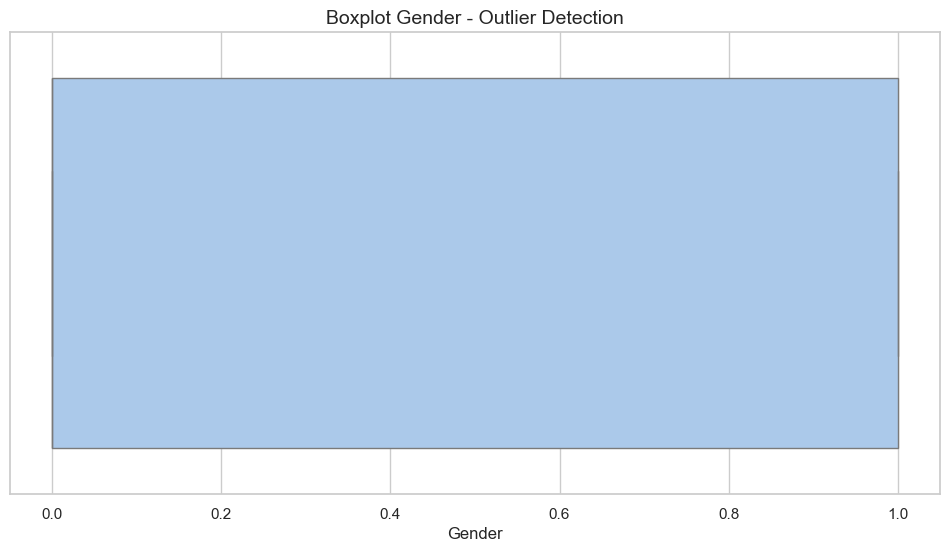

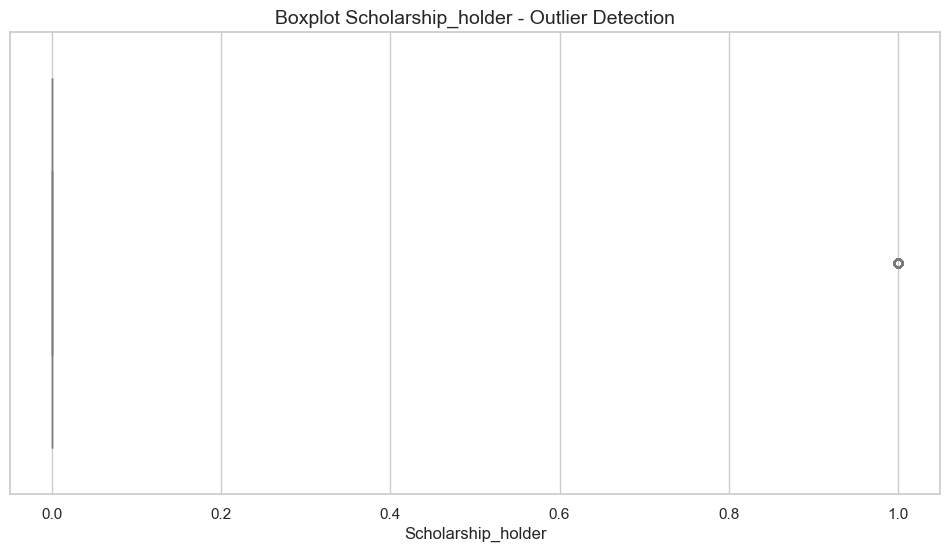

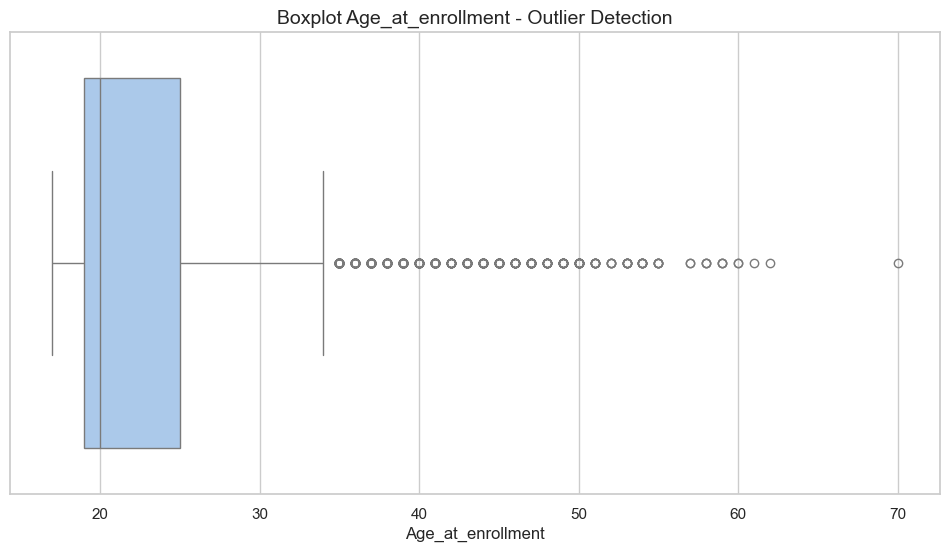

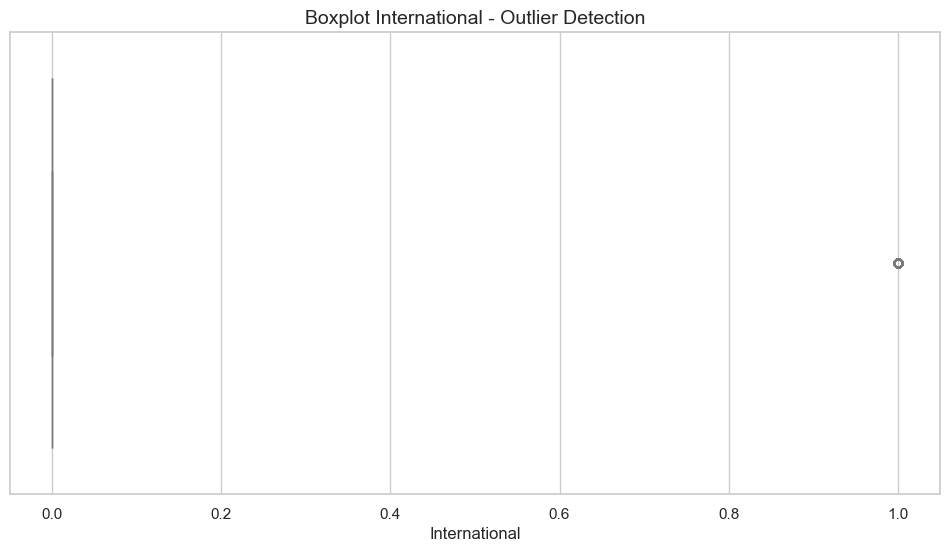

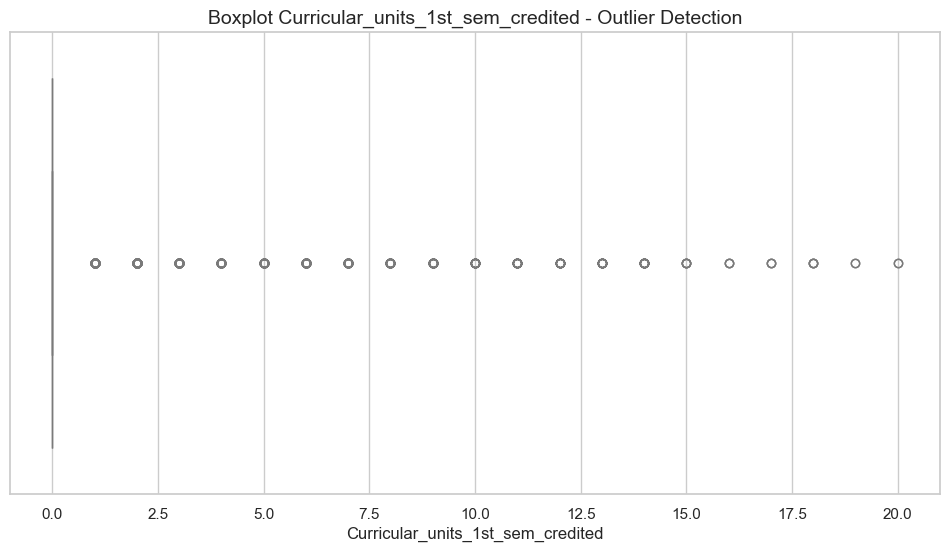

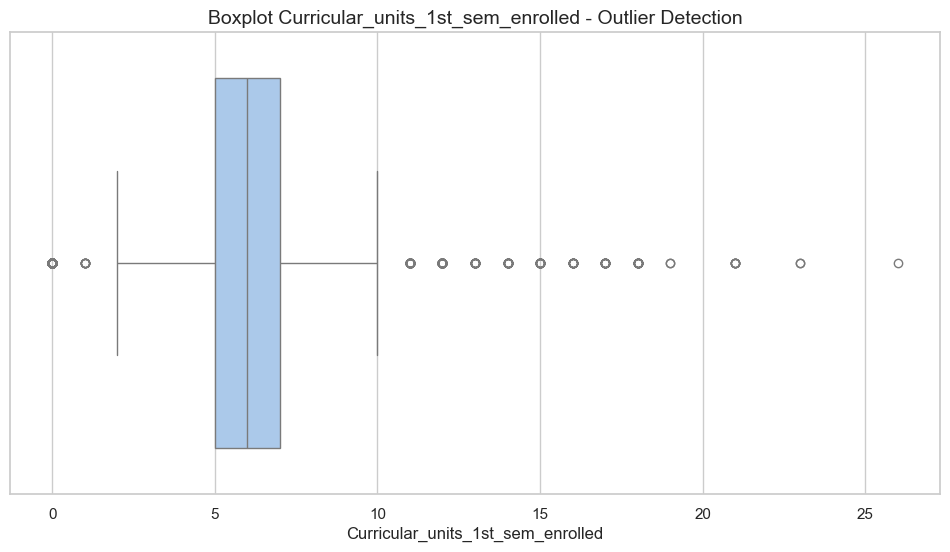

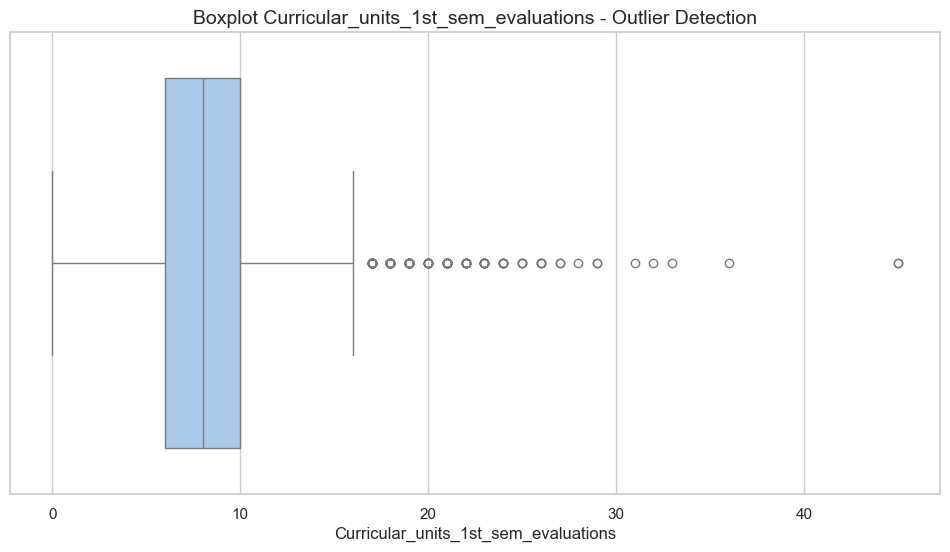

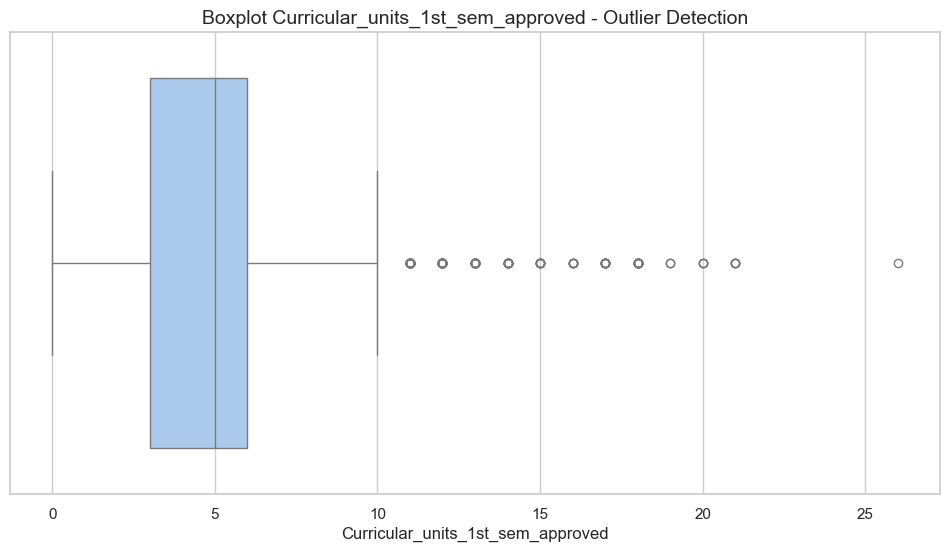

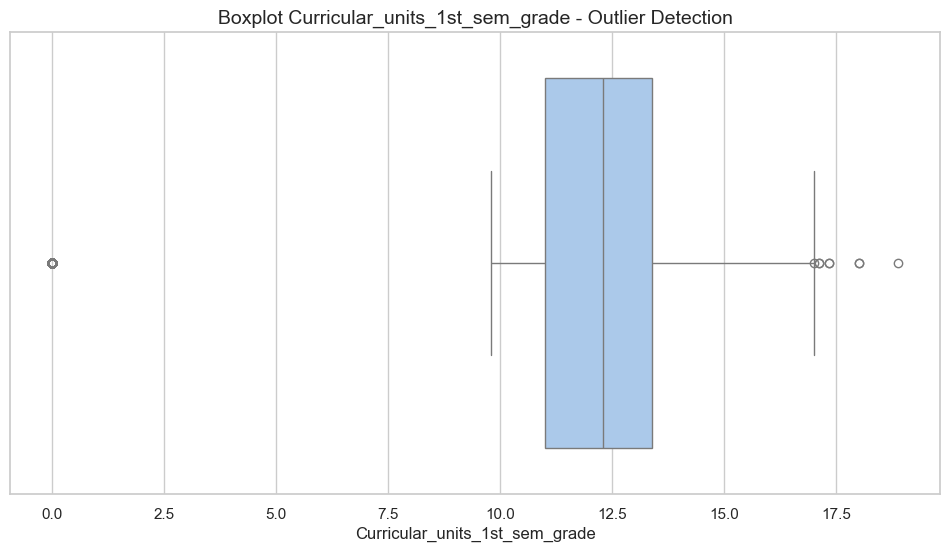

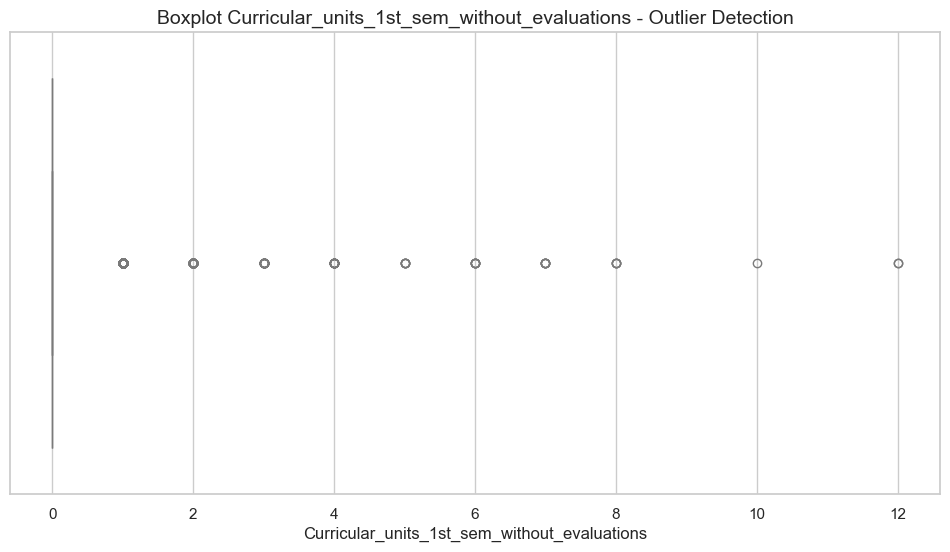

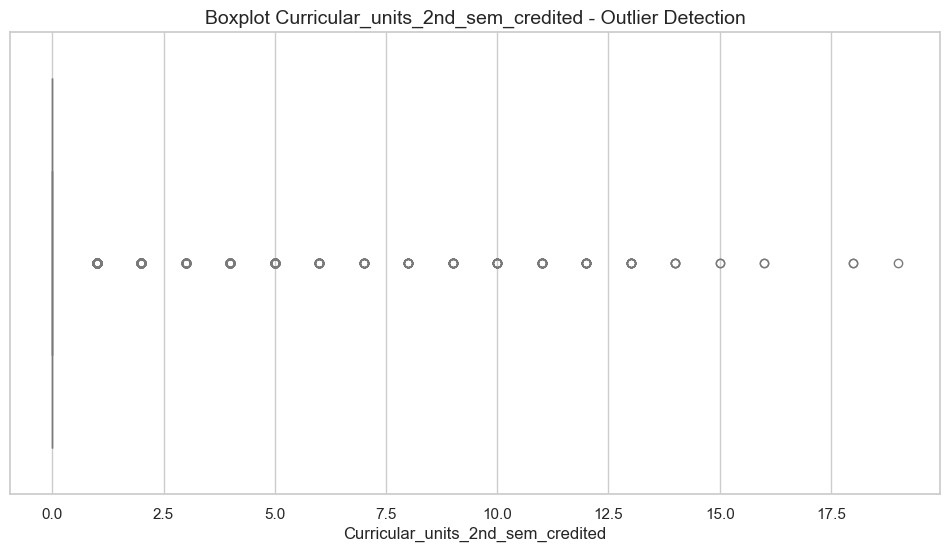

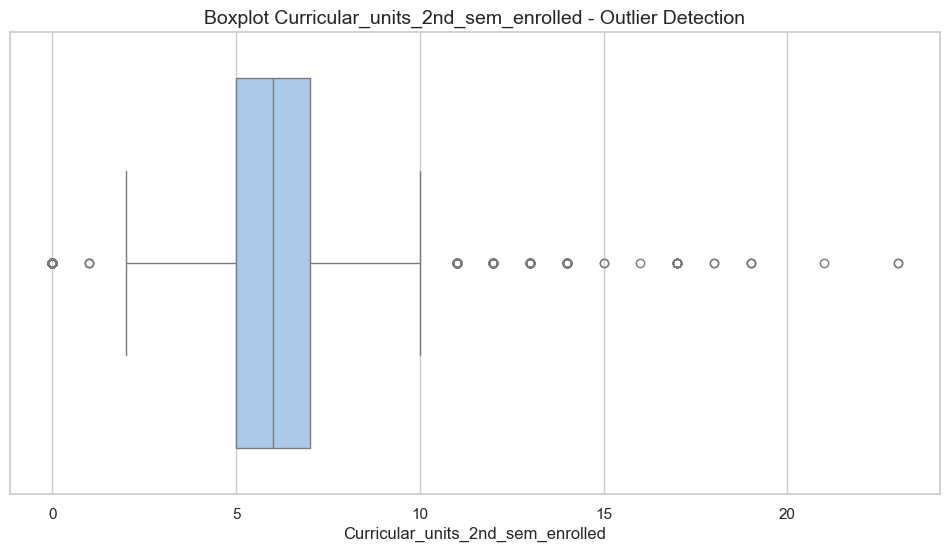

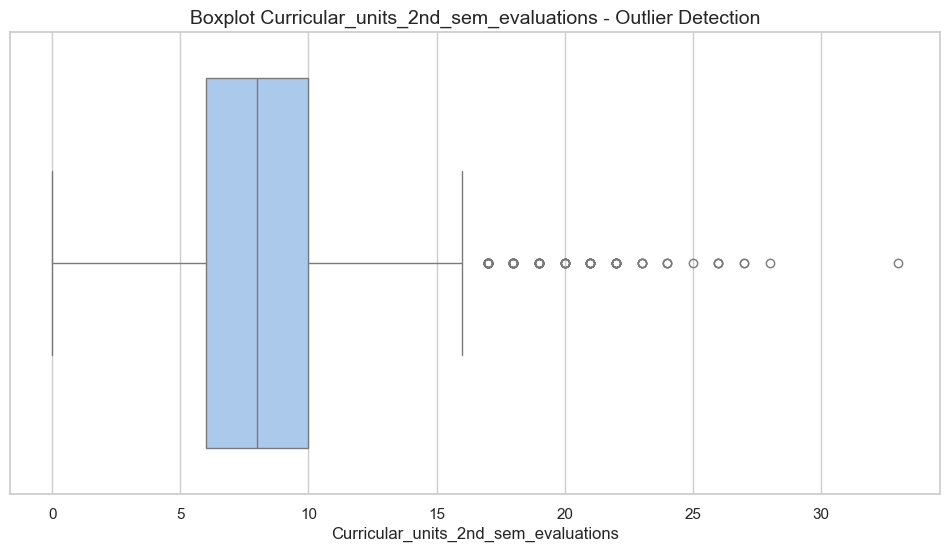

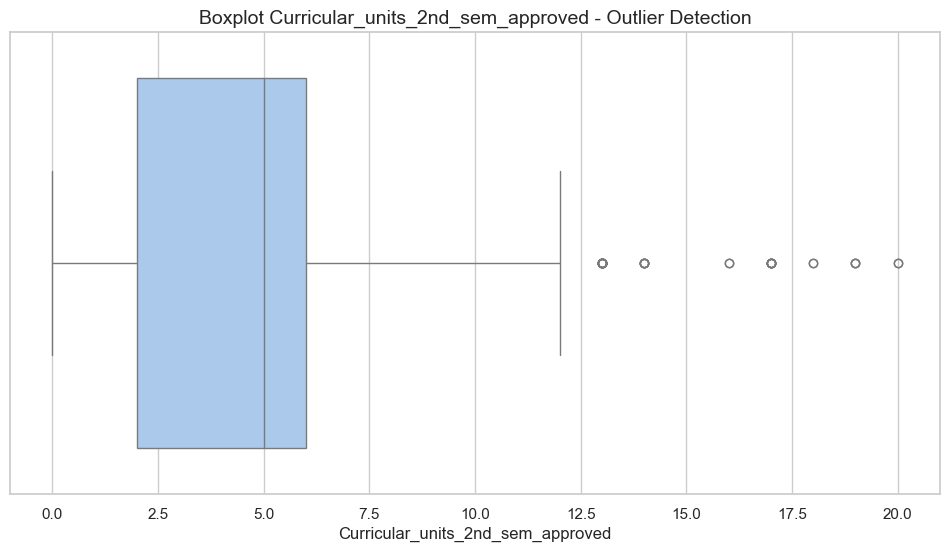

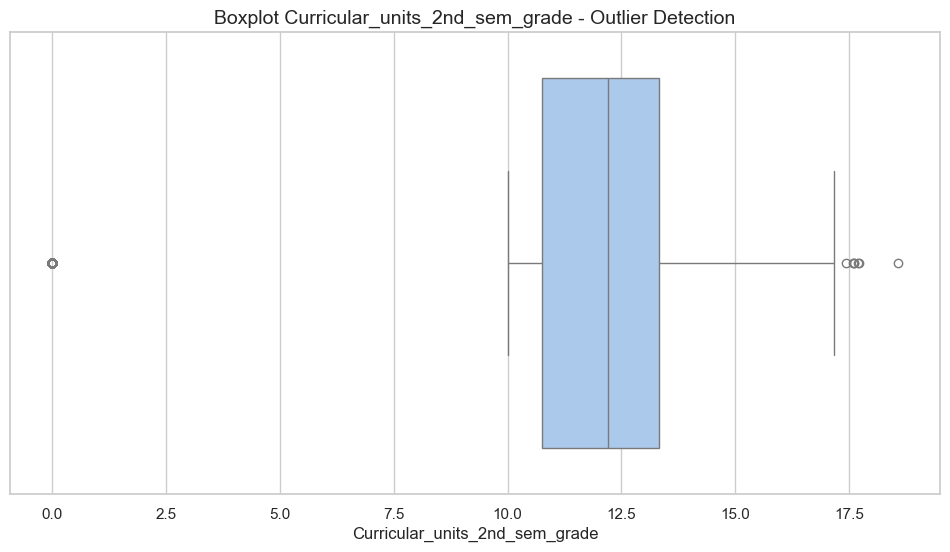

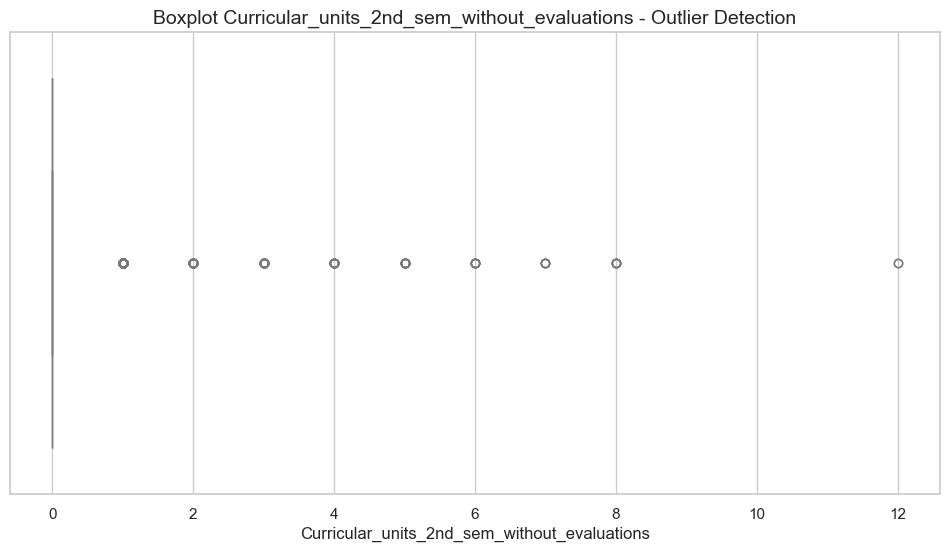

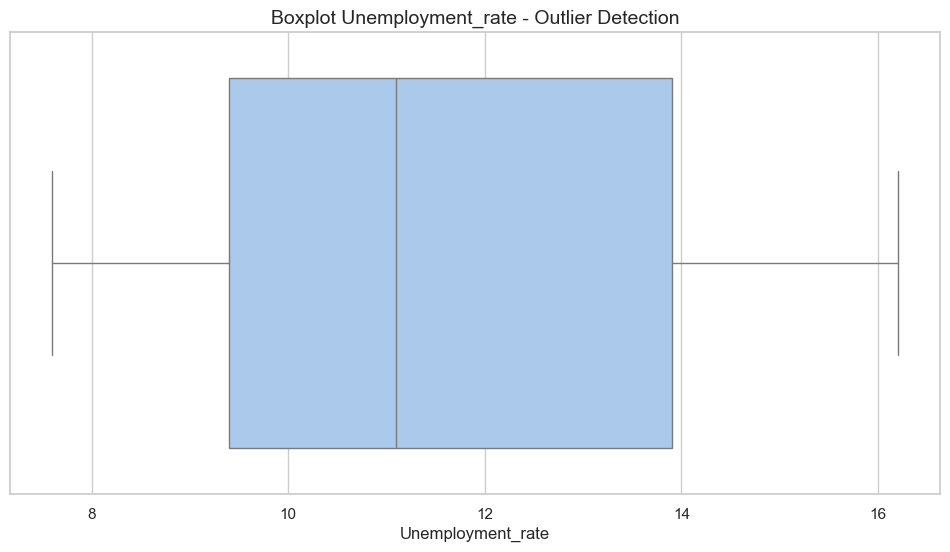

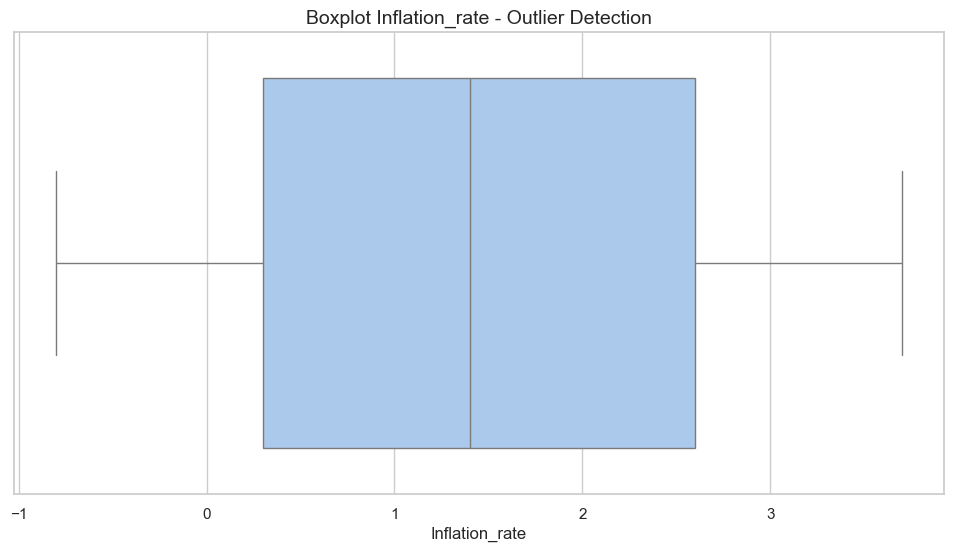

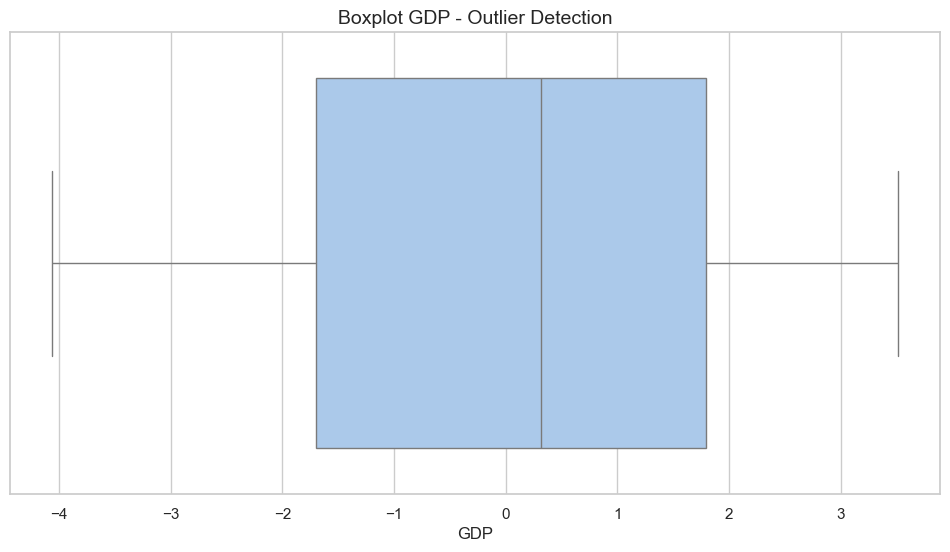

In [8]:
# Visualisasi distribusi data dengan Boxplot
for col in num:
    if col in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x=col)
        plt.title(f'Boxplot {col} - Outlier Detection')
        plt.show()

**Insight:**
- Dataset ini berisi 4.424 entri dengan 37 kolom, mencakup berbagai aspek terkait mahasiswa, termasuk latar belakang pendidikan, status ekonomi, dan faktor akademik. Berikut ini penjelasan beberapa komponen utama data yang relevan untuk analisis.
#### Komponen Utama dalam Data
- Status – Kolom target yang menunjukkan status akademik mahasiswa, apakah masih aktif, dropout, atau lulus.
- Admission_grade – Nilai masuk mahasiswa, bisa menjadi faktor prediksi keberhasilan akademik.
- Age_at_enrollment – Usia saat masuk perguruan tinggi, bisa berpengaruh terhadap performa akademik dan penyelesaian studi.
- Scholarship_holder – Indikator apakah mahasiswa mendapatkan beasiswa, bisa berkorelasi dengan retensi dan kinerja akademik.
- Tuition_fees_up_to_date – Status pembayaran biaya kuliah, yang mungkin memengaruhi kemungkinan dropout.
- Curricular_units_1st_sem & Curricular_units_2nd_sem – Menunjukkan jumlah mata kuliah yang diambil dan diselesaikan dalam setiap semester, relevan untuk mengukur progres akademik.
- Unemployment_rate, Inflation_rate, GDP – Faktor ekonomi yang mungkin mempengaruhi keputusan mahasiswa untuk melanjutkan studi atau berhenti.
#### Aspek yang Perlu Dibersihkan sebelum Analisis
- Missing Values – Data terlihat lengkap, tetapi tetap perlu dicek untuk kemungkinan nilai kosong tersembunyi.
- Inconsistencies – perlu pengecekan kategorikal dalam atribut seperti Marital_status, Course, dan Application_mode.
- Outliers – Variabel Admission_grade, Curricular_units_grade, dan faktor ekonomi perlu dicek untuk outlier yang bisa memengaruhi analisis.
- Feature Engineering – Bisa dibuat fitur baru seperti rasio mata kuliah yang diambil terhadap yang diselesaikan atau pengaruh kondisi ekonomi terhadap retensi mahasiswa.



## Data Preparation / Preprocessing

# Data Cleaning

In [9]:
import pandas as pd

# Load dataset dari file CSV
df = pd.read_csv("data.csv", sep=';')

# Mapping label kategorikal
marital_status_map = {
    "1": "single", "2": "married", "3": "widower",
    "4": "divorced", "5": "facto_union", "6": "separated"
}

application_mode_map = {
    "1": "1st_phase_general", "2": "ord_612_93", "5": "azores_special",
    "7": "other_higher_course", "10": "ord_854_B_99", "15": "int_student_bach",
    "16": "madeira_special", "17": "2nd_phase_general", "18": "3rd_phase_general",
    "26": "ord_533_A_99_b2", "27": "ord_533_A_99_b3", "39": "over_23",
    "42": "transfer", "43": "course_change", "44": "tech_diploma",
    "51": "change_institution_course", "53": "short_cycle_diploma", "57": "int_institution_change"
}

course_map = {
    "33": "biofuel_tech", "171": "anim_multimedia", "8014": "social_service_evening",
    "9003": "agronomy", "9070": "comm_design", "9085": "vet_nursing",
    "9119": "informatics_eng", "9130": "equinculture", "9147": "management",
    "9238": "social_service", "9254": "tourism", "9500": "nursing",
    "9556": "oral_hygiene", "9670": "marketing_mgmt", "9773": "journalism",
    "9853": "basic_education", "9991": "management_evening"
}

# Kolom kategorikal yang akan dibersihkan
categorical_maps = {
    'Marital_status': marital_status_map,
    'Application_mode': application_mode_map,
    'Course': course_map
}

# Bersihkan dan mapping
for col, mapping in categorical_maps.items():
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].map(mapping).fillna(df[col])

# Tampilkan nilai unik setelah pembersihan
for col in categorical_maps:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())



Unique values in 'Marital_status':
['single' 'married' 'divorced' 'widower' 'facto_union' 'separated']

Unique values in 'Application_mode':
['2nd_phase_general' 'int_student_bach' '1st_phase_general' 'over_23'
 '3rd_phase_general' 'short_cycle_diploma' 'tech_diploma'
 'change_institution_course' 'course_change' 'other_higher_course'
 'transfer' 'madeira_special' 'azores_special' 'ord_612_93' 'ord_854_B_99'
 'int_institution_change' 'ord_533_A_99_b2' 'ord_533_A_99_b3']

Unique values in 'Course':
['anim_multimedia' 'tourism' 'comm_design' 'journalism'
 'social_service_evening' 'management_evening' 'nursing' 'social_service'
 'marketing_mgmt' 'basic_education' 'vet_nursing' 'equinculture'
 'oral_hygiene' 'management' 'agronomy' 'biofuel_tech' 'informatics_eng']


In [10]:
df.isna().sum()

Marital_status                                  0
Application_mode                                0
Application_order                               0
Course                                          0
Daytime_evening_attendance                      0
Previous_qualification                          0
Previous_qualification_grade                    0
Nacionality                                     0
Mothers_qualification                           0
Fathers_qualification                           0
Mothers_occupation                              0
Fathers_occupation                              0
Admission_grade                                 0
Displaced                                       0
Educational_special_needs                       0
Debtor                                          0
Tuition_fees_up_to_date                         0
Gender                                          0
Scholarship_holder                              0
Age_at_enrollment                               0


In [11]:
# Kolom kategorikal yang akan dibersihkan
categorical_maps = {
    'Marital_status': marital_status_map,
    'Application_mode': application_mode_map,
    'Course': course_map
}

# Bersihkan nilai pada kolom Status agar konsisten (hilangkan spasi, kapitalisasi)
df['Status'] = df['Status'].astype(str).str.strip().str.capitalize()

# Hitung persentase mahasiswa dengan status Dropout
total_mahasiswa = len(df)
jumlah_dropout = (df['Status'] == 'Dropout').sum()
persentase_dropout = (jumlah_dropout / total_mahasiswa) * 100

print(f"Jumlah mahasiswa Dropout: {jumlah_dropout} dari {total_mahasiswa} ({persentase_dropout:.2f}%)")

# Bersihkan dan mapping
for col, mapping in categorical_maps.items():
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].map(mapping).fillna(df[col])

# Tampilkan nilai unik setelah pembersihan
for col in categorical_maps:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())

# --- Deteksi & Tangani Outlier dengan Format dfc.copy() ---
dfc = df.copy()
num = dfc.select_dtypes(exclude='object').columns
outlier_columns = []

for col in num:
    Q1 = dfc[col].quantile(0.25)
    Q3 = dfc[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outlier_indices = dfc[(dfc[col] < Q1 - outlier_step) | (dfc[col] > Q3 + outlier_step)].index

    if outlier_indices.any():
        outlier_columns.append(col)

cols_to_handle = [col for col in outlier_columns if col not in ['Attrition', 'PerformanceRating']]

for col in cols_to_handle:
    Q1 = dfc[col].quantile(0.25)
    Q3 = dfc[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    dfo = dfc[(dfc[col] >= lower_limit) & (dfc[col] <= upper_limit)]
    print(f"\nKolom: {col}")
    print('Baris sebelum menangani outliers :', dfc.shape[0])
    print('Baris setelah menangani outliers :', dfo.shape[0])

# Simpan dataset hasil cleaning sederhana
dfc.to_csv("cleaned_dataset.csv", index=False)

print("\nDataset saved to 'cleaned_dataset.csv'")

Jumlah mahasiswa Dropout: 1421 dari 4424 (32.12%)

Unique values in 'Marital_status':
['single' 'married' 'divorced' 'widower' 'facto_union' 'separated']

Unique values in 'Application_mode':
['2nd_phase_general' 'int_student_bach' '1st_phase_general' 'over_23'
 '3rd_phase_general' 'short_cycle_diploma' 'tech_diploma'
 'change_institution_course' 'course_change' 'other_higher_course'
 'transfer' 'madeira_special' 'azores_special' 'ord_612_93' 'ord_854_B_99'
 'int_institution_change' 'ord_533_A_99_b2' 'ord_533_A_99_b3']

Unique values in 'Course':
['anim_multimedia' 'tourism' 'comm_design' 'journalism'
 'social_service_evening' 'management_evening' 'nursing' 'social_service'
 'marketing_mgmt' 'basic_education' 'vet_nursing' 'equinculture'
 'oral_hygiene' 'management' 'agronomy' 'biofuel_tech' 'informatics_eng']

Kolom: Application_order
Baris sebelum menangani outliers : 4424
Baris setelah menangani outliers : 3883

Kolom: Daytime_evening_attendance
Baris sebelum menangani outliers : 44

In [12]:
# Membuat fitur one-hot untuk Status
dfc_encoded = dfc.copy()
dfc_encoded['Status_Dropout'] = (dfc_encoded['Status'] == 'Dropout').astype(int)
dfc_encoded['Status_Enrolled'] = (dfc_encoded['Status'] == 'Enrolled').astype(int)
dfc_encoded['Status_Graduate'] = (dfc_encoded['Status'] == 'Graduate').astype(int)

target_columns = ['Status_Dropout', 'Status_Enrolled', 'Status_Graduate']

for target_column in target_columns:
    numeric_columns = dfc_encoded.select_dtypes(include=np.number).columns
    correlation_with_target = dfc_encoded[numeric_columns].corrwith(dfc_encoded[target_column])
    sorted_correlation = correlation_with_target.sort_values(ascending=False)
    print("Korelasi antara fitur-fitur dan kolom target", target_column + ":")
    print(sorted_correlation)
    print("\n")

Korelasi antara fitur-fitur dan kolom target Status_Dropout:
Status_Dropout                                  1.000000
Age_at_enrollment                               0.254215
Debtor                                          0.229407
Gender                                          0.203983
Curricular_units_2nd_sem_without_evaluations    0.079901
Mothers_qualification                           0.064958
Curricular_units_1st_sem_without_evaluations    0.054230
Previous_qualification                          0.049379
Inflation_rate                                  0.027826
Fathers_qualification                           0.018295
Unemployment_rate                               0.012980
Nacionality                                     0.008346
Educational_special_needs                       0.002806
International                                  -0.010360
Mothers_occupation                             -0.021999
Fathers_occupation                             -0.024260
Curricular_units_1st_sem_cr

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   object 
 1   Application_mode                              4424 non-null   object 
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   object 
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

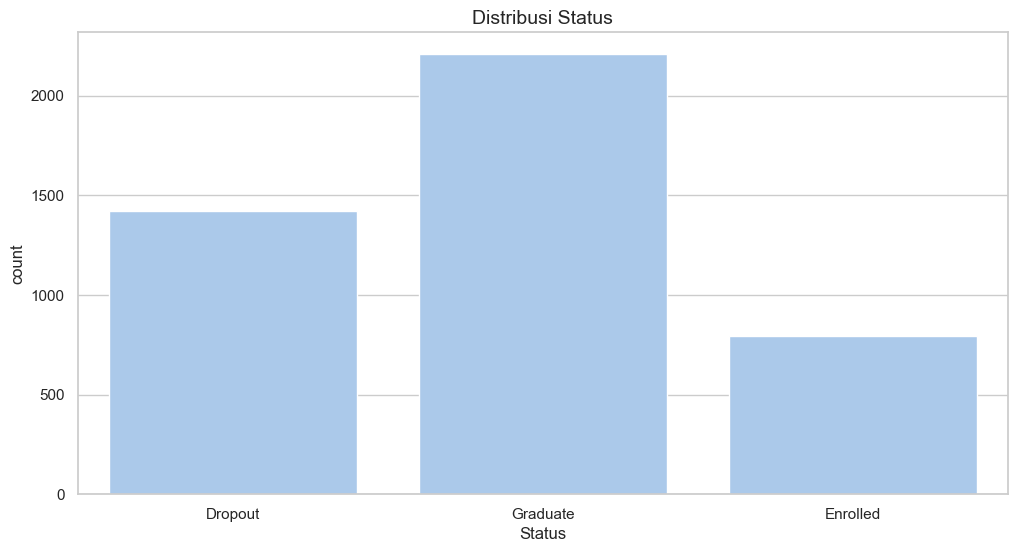

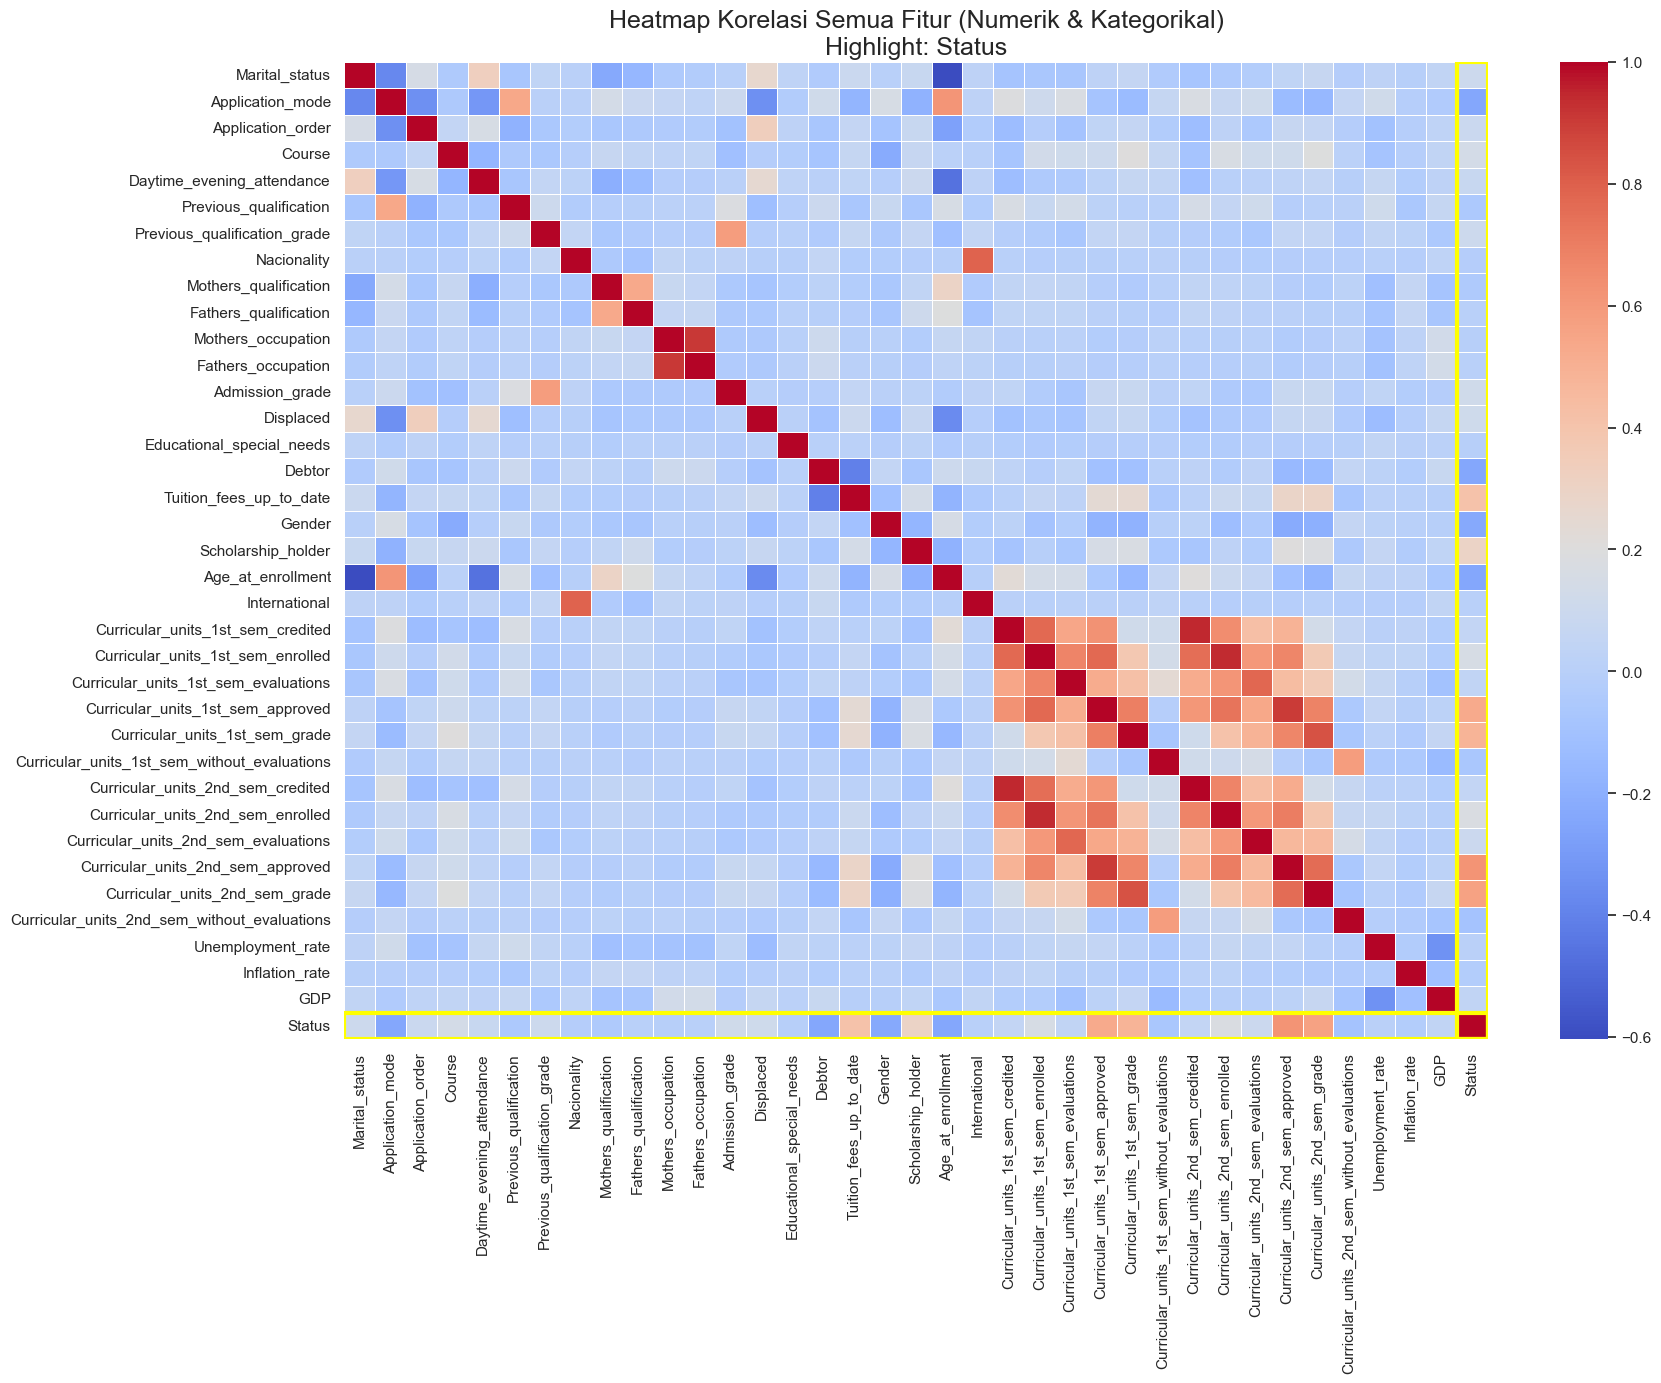

In [13]:
# --- Analisis Awal Dataset ---
dfc = pd.read_csv("cleaned_dataset.csv")
print(dfc.info())
print(dfc.describe(include='all'))
print(dfc.head())

# Distribusi target
sns.countplot(data=dfc, x='Status')
plt.title('Distribusi Status')
plt.show()

# Korelasi antar semua fitur (kategorikal akan diencode)
dfc_encoded = dfc.copy()
for col in dfc_encoded.select_dtypes(include='object').columns:
    dfc_encoded[col] = dfc_encoded[col].astype('category').cat.codes

corr_all = dfc_encoded.corr()
plt.figure(figsize=(18, 14))
attr_idx = corr_all.columns.get_loc('Status')
sns.heatmap(
    corr_all,
    annot=False,
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)
plt.gca().add_patch(plt.Rectangle((attr_idx, 0), 1, corr_all.shape[0], fill=False, edgecolor='yellow', lw=3))
plt.gca().add_patch(plt.Rectangle((0, attr_idx), corr_all.shape[1], 1, fill=False, edgecolor='yellow', lw=3))
plt.title('Heatmap Korelasi Semua Fitur (Numerik & Kategorikal)\nHighlight: Status', fontsize=18)
plt.tight_layout()
plt.show()

#### Status memiliki korelasi positif dengan:
- Curricular_units_1st_sem_enrolled, Curricular_units_2nd_sem_enrolled
- Curricular_units_1st_sem_without_evaluations, Curricular_units_2nd_sem_without_evaluations
- Debtor dan Scholarship_holder

Mahasiswa yang mengambil banyak mata kuliah tapi tidak menyelesaikan evaluasi, serta yang punya beban finansial atau bergantung pada beasiswa, lebih cenderung dropout.

#### Status memiliki korelasi negatif dengan:
- Curricular_units_1st_sem_grade, Curricular_units_2nd_sem_grade
- Curricular_units_1st_sem_approved, Curricular_units_2nd_sem_approved
- Tuition_fees_up_to_date, Admission_grade
Mahasiswa yang meraih nilai tinggi, banyak unit disetujui, dan tertib bayar, lebih cenderung lulus/bertahan.

#### keterangan korelasi:
1. Faktor yang Mempengaruhi Dropout (Status_Dropout)
- Age_at_enrollment (0.25): Mahasiswa yang lebih tua saat mendaftar cenderung lebih mungkin mengalami dropout.
- Debtor (0.23): Mahasiswa yang memiliki hutang cenderung memiliki risiko lebih tinggi untuk keluar.
- Gender (0.20): Korelasi positif menunjukkan bahwa faktor gender berkontribusi terhadap dropout.
- Curricular_units_2nd_sem_without_evaluations (0.08): Mahasiswa yang tidak mengikuti evaluasi pada semester kedua memiliki peluang lebih besar untuk dropout.
- Tuition_fees_up_to_date (-0.43): Semakin teratur membayar biaya kuliah, semakin kecil kemungkinan mahasiswa dropout.
- Curricular_units_1st_sem_approved (-0.48) & Curricular_units_2nd_sem_approved (-0.57): Mahasiswa yang berhasil menyelesaikan lebih banyak mata kuliah lebih kecil kemungkinannya untuk dropout.
- Status_Graduate (-0.69): Semakin besar keterlibatan akademik, semakin kecil kemungkinan mahasiswa dropout.
Faktor finansial, usia saat pendaftaran, dan keterlibatan akademik adalah indikator utama apakah seorang mahasiswa berisiko dropout.

2. Faktor yang Mempengaruhi Mahasiswa yang Masih Terdaftar (Status_Enrolled)
- Curricular_units_2nd_sem_evaluations (0.16) & Curricular_units_1st_sem_evaluations (0.11): Mahasiswa yang aktif dalam evaluasi akademik cenderung tetap terdaftar.
- Tuition_fees_up_to_date (0.09): Mahasiswa yang membayar biaya kuliah tepat waktu lebih mungkin untuk tetap kuliah.
- Gender (0.03): Faktor gender memiliki sedikit korelasi dengan mahasiswa yang masih aktif.
- Status_Dropout (-0.32) & Status_Graduate (-0.47): Mahasiswa yang tetap terdaftar memiliki korelasi negatif dengan mahasiswa yang dropout atau lulus.
Mahasiswa yang tetap terdaftar umumnya memiliki keterlibatan akademik tinggi dan keuangan yang stabil.

3. Faktor yang Mempengaruhi Kelulusan (Status_Graduate)
- Curricular_units_2nd_sem_approved (0.57) & Curricular_units_1st_sem_approved (0.49): Semakin banyak mata kuliah yang berhasil diselesaikan, semakin besar peluang untuk lulus.
- Tuition_fees_up_to_date (0.32) & Scholarship_holder (0.29): Mahasiswa yang membayar biaya kuliah dengan teratur atau memiliki beasiswa cenderung lebih mungkin untuk lulus.
- Admission_grade (0.12) & Previous_qualification_grade (0.11): Prestasi akademik sejak awal berkontribusi terhadap kelulusan.
- Status_Dropout (-0.69) & Status_Enrolled (-0.46): Semakin tinggi keterlibatan akademik, semakin kecil kemungkinan mahasiswa dropout atau masih terdaftar.
Faktor akademik dan keuangan memainkan peran besar dalam keberhasilan kelulusan mahasiswa.

Kesimpulan Akhir
- Mahasiswa dropout cenderung memiliki masalah finansial dan kurang keterlibatan akademik.
- Mahasiswa yang tetap terdaftar umumnya masih terlibat dalam proses akademik dan memiliki stabilitas finansial.
- Mahasiswa yang lulus memiliki keterlibatan akademik tinggi dan kondisi finansial yang lebih stabil.





## Modeling

In [14]:
# Copy dataframe agar tidak mengubah aslinya
df_simplified = dfc.copy()

# 1. Marital Status
marital_map = {
    'single': 'Single',
    'married': 'Married/Union',
    'facto_union': 'Married/Union',
    'widower': 'Separated/Divorced/Widower',
    'divorced': 'Separated/Divorced/Widower',
    'separated': 'Separated/Divorced/Widower'
}
df_simplified['Marital_status'] = df_simplified['Marital_status'].map(marital_map).fillna('Other')

# Tambahkan filter usia (misal: hanya mahasiswa usia >= 17 tahun)
df_simplified = df_simplified[df_simplified['Age_at_enrollment'] >= 17]

# Label usia berdasarkan range tertentu
def label_usia(age):
    if age < 20:
        return '17-19'
    elif 20 <= age < 23:
        return '20-22'
    elif 23 <= age < 26:
        return '23-25'
    elif 26 <= age < 30:
        return '26-29'
    else:
        return '30+'

df_simplified['Age_group'] = df_simplified['Age_at_enrollment'].apply(label_usia)

# 2. Application Mode
def simplify_app_mode(x):
    general = ['1st_phase_general', '2nd_phase_general', '3rd_phase_general']
    special = ['ord_612_93', 'azores_special', 'ord_854_B_99', 'int_student_bach', 'madeira_special', 'ord_533_A_99_b2', 'ord_533_A_99_b3']
    transfer = ['over_23', 'transfer', 'course_change', 'tech_diploma', 'change_institution_course', 'short_cycle_diploma', 'int_institution_change']
    if x in general:
        return 'General'
    elif x in special:
        return 'Special/Island/Ordinance'
    elif x in transfer:
        return 'Transfer/Change'
    else:
        return 'Other'
df_simplified['Application_mode'] = df_simplified['Application_mode'].apply(simplify_app_mode)

# 3. Course
course_map = {
    'informatics_eng': 'Engineering/Tech',
    'vet_nursing': 'Engineering/Tech',
    'equinculture': 'Engineering/Tech',
    'nursing': 'Health/Medicine',
    'oral_hygiene': 'Health/Medicine',
    'social_service': 'Social Sciences',
    'social_service_evening': 'Social Sciences',
    'management': 'Business/Economy',
    'management_evening': 'Business/Economy',
    'marketing_mgmt': 'Business/Economy',
    'basic_education': 'Education',
    'anim_multimedia': 'Arts/Communication',
    'comm_design': 'Arts/Communication',
    'journalism': 'Arts/Communication',
    'biofuel_tech': 'Engineering/Tech',
    'tourism': 'Business/Economy',
    'agronomy': 'Agriculture'
}
df_simplified['Course'] = df_simplified['Course'].map(course_map).fillna('Other')

# 4. Previous Qualification
def simplify_prev_qual(x):
    basic = [19, 38, 14, 15, 10, 12]
    secondary = [1, 9, 11]
    higher = [2, 3, 4, 5, 6, 39, 40, 42, 43]
    if x in basic:
        return 'Basic Education'
    elif x in secondary:
        return 'Secondary Education'
    elif x in higher:
        return 'Higher Education'
    else:
        return 'Other'
df_simplified['Previous_qualification'] = df_simplified['Previous_qualification'].apply(simplify_prev_qual)

def simplify_nationality(x):
    try:
        x = int(float(x))  # aman untuk nilai string/float seperti '1.0'
    except (ValueError, TypeError):
        return 'Other'

    if x == 1:
        return 'Portuguese'
    elif 21 <= x <= 26:
        return 'PALOP'
    elif x in [2, 6, 11, 13, 14, 17, 62, 100]:
        return 'EU'
    elif x in [101, 108, 109, 41]:
        return 'Latin America'
    else:
        return 'Other' 
    
# 6. Parental Qualification
def simplify_parent_qual(x):
    if x in [35, 36, 37, 38]:
        return 'No Schooling/Primary'
    elif x in [19, 29, 30]:
        return 'Basic Education'
    elif x in [1, 9, 10, 14]:
        return 'Secondary'
    elif x in [2, 3, 4, 5, 6, 40, 41, 42, 43, 44]:
        return 'Higher Education'
    else:
        return 'Other'
df_simplified['Mothers_qualification'] = df_simplified['Mothers_qualification'].apply(simplify_parent_qual)
df_simplified['Fathers_qualification'] = df_simplified['Fathers_qualification'].apply(simplify_parent_qual)

# 7. Parental Occupation
def simplify_parent_occ(x):
    if x in [1, 112, 114]:
        return 'Managers'
    elif x in [2, 122, 123, 124]:
        return 'Professionals'
    elif x in [3, 131, 132, 133, 134, 135]:
        return 'Technicians'
    elif x in [4, 141, 142, 143, 144]:
        return 'Clerical'
    elif x in [5, 151, 152, 153]:
        return 'Service/Sales'
    elif x in [6, 161, 162, 163]:
        return 'Agriculture/Fishery'
    elif x in [7, 171, 172, 173, 174, 175]:
        return 'Craft/Trade'
    elif x in [8, 181, 182, 183]:
        return 'Plant/Machine'
    elif x in [9, 191, 192, 193, 194]:
        return 'Elementary'
    elif x in [90, 99]:
        return 'Unknown'
    else:
        return 'Other'
    

# 8. Gender
def simplify_gender(x):
    if x == 1:
        return 'Male'
    elif x == 0:
        return 'Female'
    else:
        return 'Other'
df_simplified['Gender'] = df_simplified['Gender'].apply(simplify_gender)


df_simplified['Mothers_occupation'] = df_simplified['Mothers_occupation'].apply(simplify_parent_occ)
df_simplified['Fathers_occupation'] = df_simplified['Fathers_occupation'].apply(simplify_parent_occ)


# Simpan dataframe hasil simplifikasi ke file CSV dan XLSX
df_simplified.to_csv('cleaned_dataset_labeled.csv', index=False)
df_simplified.to_excel('cleaned_dataset_labeled.xlsx', index=False)
# df_simplified siap untuk encoding/analisis selanjutnya

### Melakukan Labeling pada Fitur Tertentu
1. Marital Status
- Mengelompokkan status pernikahan menjadi Single, Married/Union, Separated/Divorced/Widower, atau Other.

2. Application Mode
- Mengelompokkan mode aplikasi menjadi General, Special/Island/Ordinance, Transfer/Change, atau Other.
3. Course
- Mengelompokkan berbagai jurusan ke dalam kategori bidang seperti Engineering/Tech, Health/Medicine, Social Sciences, Business/Economy, Education, Arts/Communication, dan Agriculture.

4. Previous Qualification
- Mengelompokkan kualifikasi pendidikan sebelumnya ke dalam Basic Education, Secondary Education, Higher Education, atau Other.

5. Nationality
- Mengelompokkan kewarganegaraan menjadi Portuguese, PALOP, EU, Latin America, atau Other.

6. Parental Qualification
- Menyederhanakan tingkat pendidikan orang tua menjadi No Schooling/Primary, Basic Education, Secondary, Higher Education, atau Other.

7. Parental Occupation
- Mengelompokkan pekerjaan orang tua ke dalam kategori seperti Managers, Professionals, Technicians, Clerical, Service/Sales, Agriculture/Fishery, Craft/Trade, Plant/Machine, Elementary, Unknown, atau Other.

8. Age Category
- Mengelompokkan umur menjadi Teen/Young Adult, Young Adult, Adult, Middle Age, atau Senior.


Menyimpan Data ke Excel Setelah labeling selesai, hasil dataset baru disimpan ke file student_data_labeled.xlsx dengan perintah to_excel(). Ini memastikan data yang telah ditransformasikan dapat digunakan kembali untuk analisis lebih lanjut.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Load cleaned dan labeled dataset
df = pd.read_csv('cleaned_dataset.csv')

# Encode Target
# Gabungkan Graduate dan Enrolled menjadi 0 (Non Dropout), Dropout menjadi 1
df['Status'] = df['Status'].str.strip().str.capitalize()
status_mapping = {'Graduate': 0, 'Enrolled': 0, 'Dropout': 1}
df['Status'] = df['Status'].map(status_mapping)

# Hapus baris dengan Status tidak dikenali (None/NaN)
df = df.dropna(subset=['Status'])

# Hanya simpan Dropout dan Non-Dropout
df = df[df['Status'].isin([0, 1])]

# Cek ringkasan jumlah
print(df['Status'].value_counts())

# Drop rows with NaN pada target (terutama jika mapping gagal)
df = df.dropna(subset=['Status'])

# Identify Columns
categorical_cols = [
    'Marital_status', 'Application_mode', 'Course', 'Daytime_evening_attendance',
    'Previous_qualification', 'Nacionality', 'Mothers_qualification',
    'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation',
    'Displaced', 'Educational_special_needs', 'Debtor',
    'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'International'
]
numerical_cols = [
    'Application_order', 'Previous_qualification_grade', 'Admission_grade',
    'Age_at_enrollment', 'Curricular_units_1st_sem_credited',
    'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations',
    'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade',
    'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited',
    'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations',
    'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade',
    'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate',
    'Inflation_rate', 'GDP'
]

# Drop unused/extra columns
if 'Age_category' in df.columns:
    df = df.drop(columns=['Age_category'])

# Pastikan tipe data numerik
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN in numerical columns
df = df.dropna(subset=numerical_cols)

# One-Hot Encoding 
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Scaling
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Step 6: Split Features & Target
X = df_encoded.drop(columns='Status')
y = df_encoded['Status'].astype(int)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Print Columns
print("Kolom pada X_train:")
print(list(X_train.columns))

print("\nKolom pada X_test:")
print(list(X_test.columns))

Status
0    3003
1    1421
Name: count, dtype: int64
Kolom pada X_train:
['Application_order', 'Previous_qualification_grade', 'Admission_grade', 'Age_at_enrollment', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation_rate', 'GDP', 'Marital_status_facto_union', 'Marital_status_married', 'Marital_status_separated', 'Marital_status_single', 'Marital_status_widower', 'Application_mode_2nd_phase_general', 'Application_mode_3rd_phase_general', 'Application_mode_azores_special', 'Application_mode_change_institution_course', 'Application_mode_course_chan

0 artinya status selain Dropout (Enrolled dan Graduated)
1 artinya Dropout

### Preprocessing dan Penyeimbangan Data

Kode ini menjalankan tahapan preprocessing lanjutan untuk persiapan data sebelum dilakukan pemodelan machine learning. Berikut penjelasan tiap langkahnya:

1. Pembersihan dan Transformasi Data
- Dataset cleaned_dataset.csv dimuat.
- Kolom target Status (dengan nilai Graduate serta Enrolled dan Dropout) diubah menjadi format numerik: 0, dan 1.
- Fitur diklasifikasikan menjadi numerik dan kategorikal.
- Fitur kategorikal ditransformasikan menggunakan one-hot encoding agar bisa digunakan dalam model machine learning.
- Fitur numerik dinormalisasi menggunakan StandardScaler agar semua fitur numerik berada pada skala yang sama.

2. Penyeimbangan Kelas & Pembagian Data
- Karena kolom target Status memiliki distribusi kelas yang tidak seimbang (misalnya Dropout lebih sedikit), digunakan teknik SMOTE (Synthetic Minority Over-sampling Technique) untuk menyeimbangkan kelas minoritas.
- Data kemudian dibagi menjadi training set dan testing set menggunakan train_test_split dengan opsi stratifikasi untuk menjaga proporsi kelas yang seimbang pada data latih dan uji.

Hasil akhirnya adalah variabel X_train, X_test, y_train, dan y_test yang siap digunakan untuk proses pelatihan model klasifikasi prediksi status kelulusan mahasiswa.

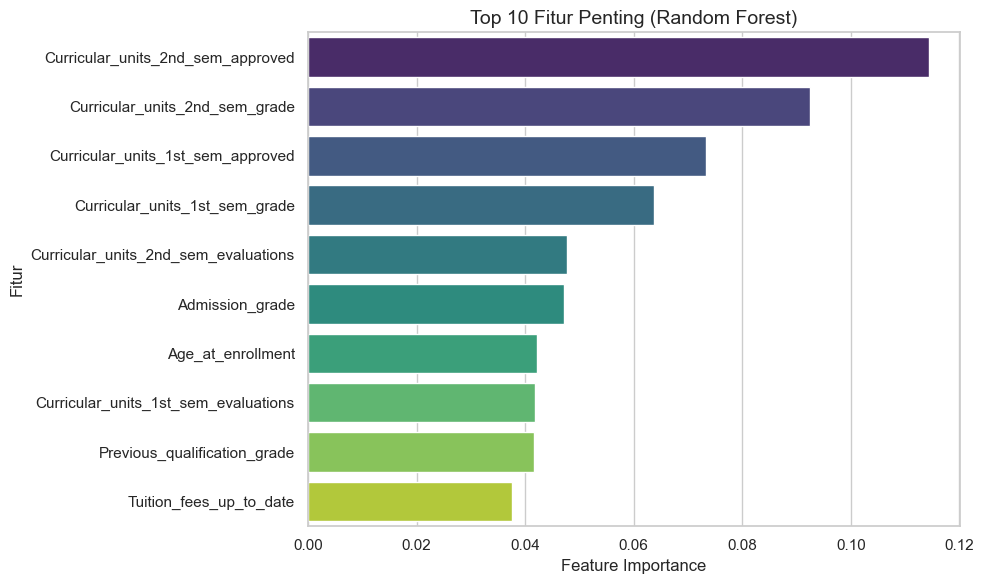

                                   Fitur  Importance
30     Curricular_units_2nd_sem_approved    0.114404
31        Curricular_units_2nd_sem_grade    0.092456
24     Curricular_units_1st_sem_approved    0.073238
25        Curricular_units_1st_sem_grade    0.063735
29  Curricular_units_2nd_sem_evaluations    0.047721
12                       Admission_grade    0.047176
19                     Age_at_enrollment    0.042201
23  Curricular_units_1st_sem_evaluations    0.041891
6           Previous_qualification_grade    0.041595
16               Tuition_fees_up_to_date    0.037678


In [16]:
from sklearn.ensemble import RandomForestClassifier


# Siapkan X dan y dari dfc_encoded
X_rf = dfc_encoded.drop(columns=['Status'])
y_rf = dfc_encoded['Status']

# Inisialisasi dan latih model Random Forest
rf = RandomForestClassifier(n_estimators=500, max_depth=30, max_features='log2', class_weight='balanced', random_state=42)
rf.fit(X_rf, y_rf)
# Ambil feature names dan importances dari model Random Forest (rf)
feature_names = rf.feature_names_in_
importances = rf.feature_importances_

# Pastikan panjang sama
if len(feature_names) != len(importances):
    raise ValueError(f"Panjang feature_names ({len(feature_names)}) dan importances ({len(importances)}) tidak sama.")

# Buat DataFrame untuk visualisasi
feat_imp_df = (
    pd.DataFrame({"Fitur": feature_names, "Importance": importances})
    .sort_values("Importance", ascending=False)
)

# Plot 10 fitur terpenting
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(10), x="Importance", y="Fitur", palette="viridis")
plt.title("Top 10 Fitur Penting (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

# Tampilkan tabel 10 fitur teratas
print(feat_imp_df.head(10))

### Feature Importance Random Forest (Hasil Model)

Model Random Forest menentukan pentingnya fitur berdasarkan kontribusi mereka dalam membagi data secara optimal di setiap pohon keputusan. Berikut adalah hasil feature importance aktual dari model pada data ini:

#### 10 Fitur Paling Penting (berdasarkan nilai importance):

1. Curricular_units_2nd_sem_approved (11.4%)
    - Jumlah mata kuliah semester 2 yang disetujui sangat menentukan risiko Drop Out.
2. Curricular_units_2nd_sem_grade (9.2%)
    - Nilai akademik semester 2 menjadi indikator utama keberhasilan studi.
3. Curricular_units_1st_sem_approved (7.3%)
    - Jumlah mata kuliah semester 1 yang disetujui juga sangat berpengaruh.
4. Curricular_units_1st_sem_grade (6.4%)
    - Nilai semester 1 menjadi indikator awal performa akademik.
5. Curricular_units_2nd_sem_evaluations (4.8%)
    - Partisipasi dalam evaluasi semester 2 menurunkan risiko Drop Out.
6. Admission_grade (4.7%)
    - Nilai masuk memberikan gambaran potensi akademik awal.
7. Age_at_enrollment (4.2%)
    - Usia saat mendaftar berpengaruh terhadap risiko Drop Out.
8. Curricular_units_1st_sem_evaluations (4.2%)
    - Partisipasi evaluasi semester 1 juga penting.
9. Previous_qualification_grade (4.2%)
    - Nilai pendidikan sebelumnya berkontribusi pada keberhasilan studi.
10. Tuition_fees_up_to_date (3.8%)
     - Keteraturan pembayaran biaya kuliah menurunkan risiko Drop Out.

#### Insight:
- Fitur akademik semester 1 & 2 (jumlah mata kuliah disetujui, nilai, evaluasi) mendominasi prediksi risiko Drop Out.
- Nilai masuk, usia saat pendaftaran, dan keteraturan pembayaran juga berpengaruh, meski lebih kecil.
- Faktor ekonomi dan demografi (seperti GDP, Unemployment_rate, dsb) memiliki pengaruh minor.

**Kesimpulan:**  
Fokus intervensi sebaiknya diarahkan pada peningkatan progres akademik mahasiswa di semester awal, monitoring nilai, dan dukungan keuangan untuk menurunkan risiko Drop Out.


In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# Definisi parameter untuk tuning XGBoost
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Stratified K-Fold untuk menjaga distribusi kelas tetap seimbang
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV untuk tuning lebih cepat
grid_search = RandomizedSearchCV(
    XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False),
    param_grid,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    n_iter=20  # Jumlah kombinasi parameter yang diuji
)



# Training model dengan Randomized Search (gunakan data hasil SMOTE)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print("Best params:", grid_search.best_params_)

# Model terbaik dari tuning
best_xgb = grid_search.best_estimator_

# Evaluasi model
y_pred = best_xgb.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
# Untuk binary classification, gunakan probabilitas kelas positif (Dropout = 1)
print("ROC AUC Score:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1]))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'subsample': 1.0, 'n_estimators': 700, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       601
           1       0.93      0.92      0.92       601

    accuracy                           0.92      1202
   macro avg       0.92      0.92      0.92      1202
weighted avg       0.92      0.92      0.92      1202

ROC AUC Score: 0.9747979656756209



=== Logistic Regression ===
Confusion Matrix:
[[565  36]
 [ 58 543]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       601
           1       0.94      0.90      0.92       601

    accuracy                           0.92      1202
   macro avg       0.92      0.92      0.92      1202
weighted avg       0.92      0.92      0.92      1202

ROC AUC Score: Error (y should be a 1d array, got an array of shape (1202, 2) instead.)
PR AUC (Dropout): 0.975


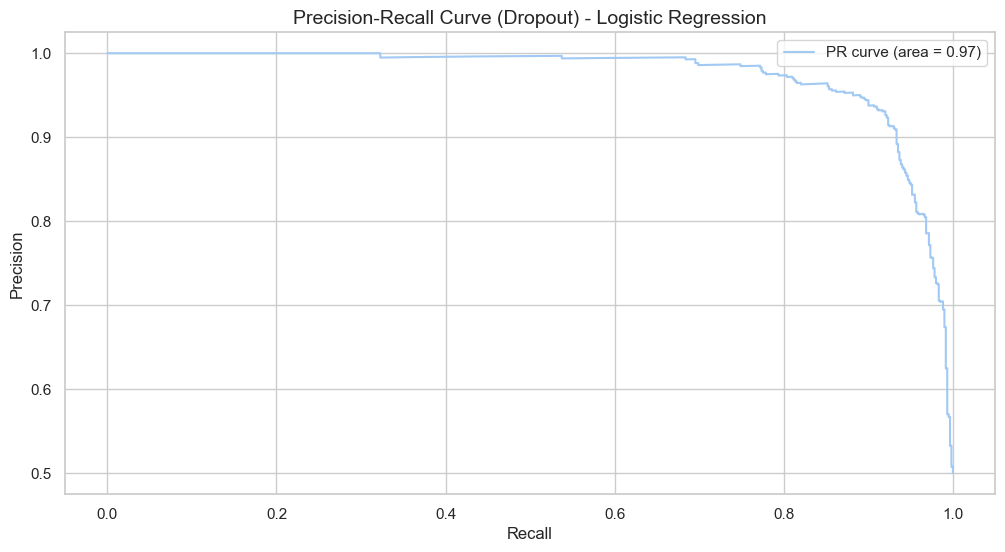

F1 Score (weighted): 0.922

=== Random Forest ===
Confusion Matrix:
[[560  41]
 [ 52 549]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       601
           1       0.93      0.91      0.92       601

    accuracy                           0.92      1202
   macro avg       0.92      0.92      0.92      1202
weighted avg       0.92      0.92      0.92      1202

ROC AUC Score: Error (y should be a 1d array, got an array of shape (1202, 2) instead.)
PR AUC (Dropout): 0.980


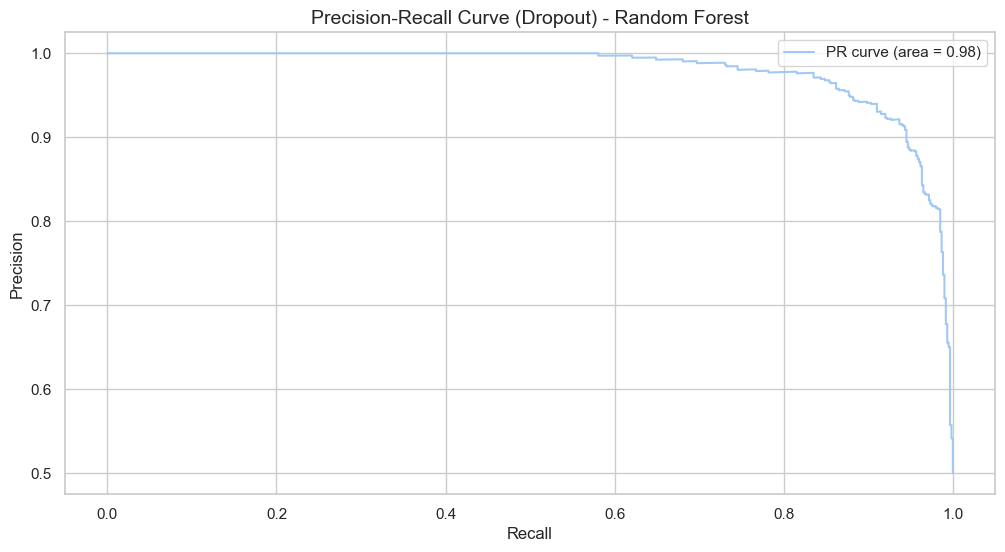

F1 Score (weighted): 0.923

=== XGBoost ===
Confusion Matrix:
[[560  41]
 [ 47 554]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       601
           1       0.93      0.92      0.93       601

    accuracy                           0.93      1202
   macro avg       0.93      0.93      0.93      1202
weighted avg       0.93      0.93      0.93      1202

ROC AUC Score: Error (y should be a 1d array, got an array of shape (1202, 2) instead.)
PR AUC (Dropout): 0.977


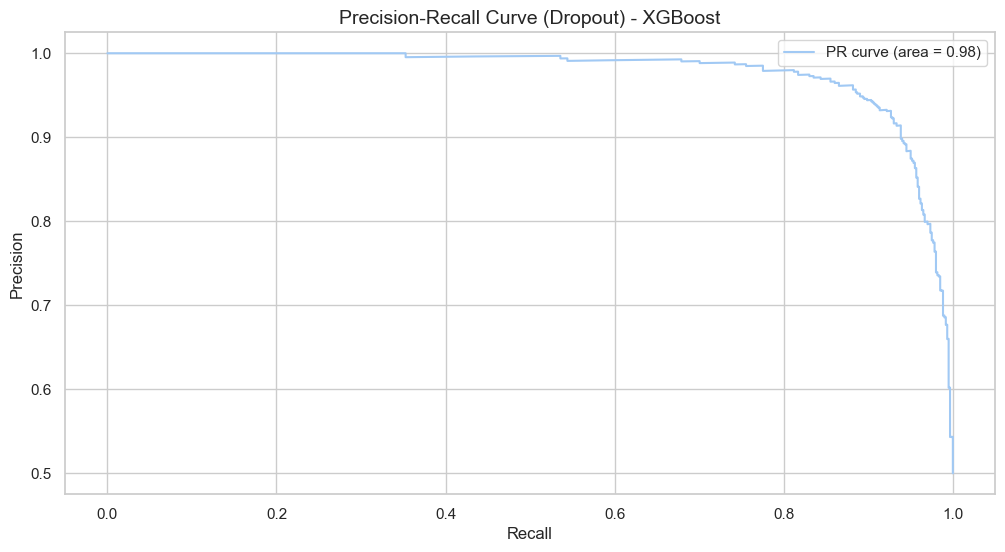

F1 Score (weighted): 0.927

=== Stacking Ensemble ===
Confusion Matrix:
[[561  40]
 [ 60 541]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       601
           1       0.93      0.90      0.92       601

    accuracy                           0.92      1202
   macro avg       0.92      0.92      0.92      1202
weighted avg       0.92      0.92      0.92      1202

ROC AUC Score: Error (y should be a 1d array, got an array of shape (1202, 2) instead.)
PR AUC (Dropout): 0.973


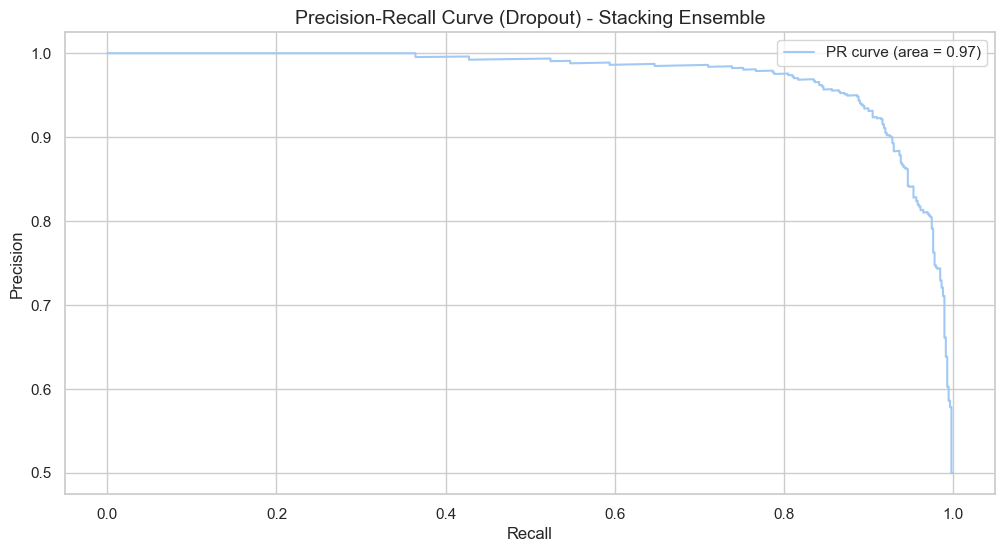

F1 Score (weighted): 0.917

=== Voting Ensemble ===
Confusion Matrix:
[[563  38]
 [ 46 555]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       601
           1       0.94      0.92      0.93       601

    accuracy                           0.93      1202
   macro avg       0.93      0.93      0.93      1202
weighted avg       0.93      0.93      0.93      1202

ROC AUC Score: Error (y should be a 1d array, got an array of shape (1202, 2) instead.)
PR AUC (Dropout): 0.982


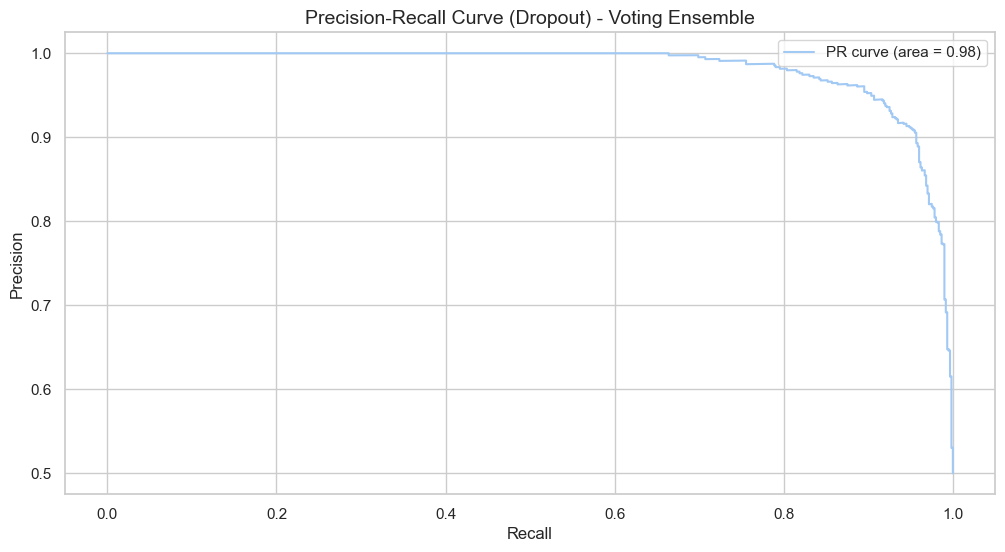

F1 Score (weighted): 0.930

Cross-Validation Scores (5-Fold):
Logistic Regression: Mean F1 = 0.8979 ± 0.0094
Random Forest: Mean F1 = 0.9006 ± 0.0106
XGBoost: Mean F1 = 0.9090 ± 0.0085
Stacking Ensemble: Mean F1 = 0.8953 ± 0.0143
Voting Ensemble: Mean F1 = 0.9134 ± 0.0077


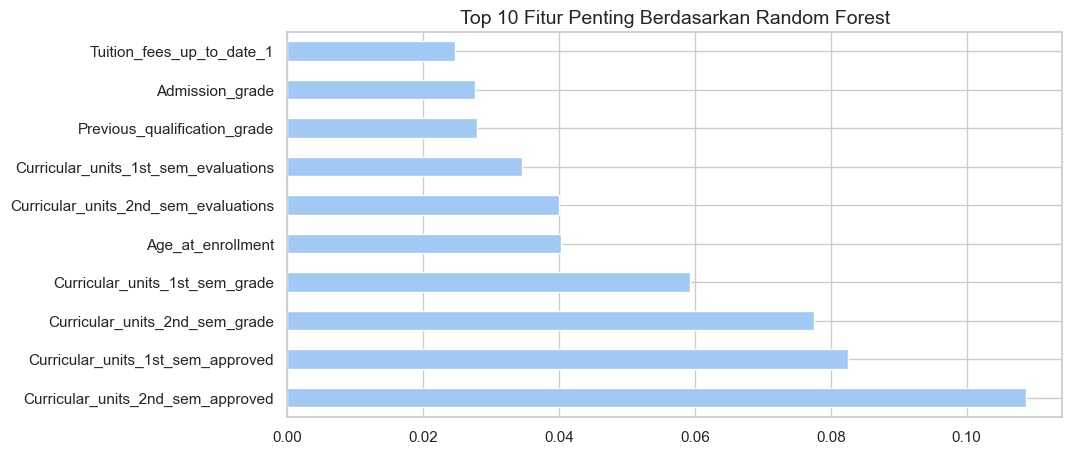

Model Voting Ensemble telah disimpan sebagai 'model_prediksi.pkl'


In [18]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, f1_score, auc

import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np

# Define evaluation function
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        try:
            roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
            print(f"ROC AUC Score: {roc_auc:.3f}")
        except Exception as e:
            print(f"ROC AUC Score: Error ({e})")
        # PR Curve for Dropout class (class 1)
        precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])
        pr_auc = auc(recall, precision)
        print(f"PR AUC (Dropout): {pr_auc:.3f}")
        # Optional: plot PR curve
        plt.figure()
        plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve (Dropout) - {name}')
        plt.legend()
        plt.show()
    print(f"F1 Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.3f}")

# **Stacking Model**
stacking_model = StackingClassifier(
    estimators=[
        ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr')),
        ('rf', RandomForestClassifier(n_estimators=500, max_depth=30, max_features='log2', class_weight='balanced', random_state=42)),
        ('xgb', XGBClassifier(n_estimators=700, max_depth=20, learning_rate=0.1, gamma=0, colsample_bytree=1.0, use_label_encoder=False, eval_metric='mlogloss'))
    ],
    final_estimator=XGBClassifier(n_estimators=300, learning_rate=0.2, max_depth=5)
)

# **Voting Model**
voting_model = VotingClassifier(
    estimators=[
        ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr')),
        ('rf', RandomForestClassifier(n_estimators=500, max_depth=30, max_features='log2', class_weight='balanced', random_state=42)),
        ('xgb', XGBClassifier(n_estimators=700, max_depth=20, learning_rate=0.1, gamma=0, colsample_bytree=1.0, use_label_encoder=False, eval_metric='mlogloss'))
    ],
    voting='soft'  # Gunakan soft voting agar probabilitas dipertimbangkan
)

# **Training dan Evaluasi Model**
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr'),
    "Random Forest": RandomForestClassifier(n_estimators=500, max_depth=30, max_features='log2', class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=700, max_depth=20, learning_rate=0.1, gamma=0, colsample_bytree=1.0, use_label_encoder=False, eval_metric='mlogloss'),
    "Stacking Ensemble": stacking_model,
    "Voting Ensemble": voting_model
}

for name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(model, X_test, y_test, name)

# **Cross-Validation untuk Semua Model**
print("\nCross-Validation Scores (5-Fold):")
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    print(f"{model_name}: Mean F1 = {scores.mean():.4f} ± {scores.std():.4f}")

# **Feature Importance dari Random Forest**
feat_importance = pd.Series(models["Random Forest"].feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
feat_importance.plot(kind='barh')
plt.title("Top 10 Fitur Penting Berdasarkan Random Forest")
plt.show()

# Save model
# Simpan model Voting Ensemble (mengganti Random Forest sebagai model utama)
joblib.dump(models["Random Forest"], "model_prediksi.pkl")
print("Model Voting Ensemble telah disimpan sebagai 'model_prediksi.pkl'")


### Pemodelan, Evaluasi, dan Interpretasi

Pada tahap ini dilakukan pelatihan dan evaluasi beberapa model machine learning untuk memprediksi status mahasiswa (Dropout, Enrolled, Graduate) berdasarkan data akademik, keuangan, dan demografis. Berikut ringkasan proses:

#### Model yang Digunakan:
1. **Logistic Regression**  
   Model linear sebagai baseline, menggunakan `class_weight='balanced'` untuk mengatasi ketidakseimbangan kelas.

2. **Random Forest Classifier**  
   Model ensemble berbasis pohon keputusan dengan 500 estimator, `max_depth=30`, dan penyesuaian class weight.

3. **XGBoost Classifier**  
   Model boosting yang kuat dengan parameter hasil tuning, digunakan untuk meningkatkan akurasi dan stabilitas prediksi.

4. **Voting Ensemble**  
   Gabungan beberapa model (Logistic Regression, Random Forest, XGBoost) dengan metode voting untuk memperoleh prediksi yang lebih stabil.

#### Evaluasi Performa:
- **Confusion Matrix** dan **Classification Report** (Accuracy, Precision, Recall, F1-Score) untuk masing-masing kelas (Graduate, Enrolled, Dropout).
- **ROC AUC Score** untuk mengukur kemampuan model dalam membedakan ketiga kelas.
- **Precision-Recall AUC (PR AUC)** khususnya untuk kelas Dropout, karena menjadi fokus utama analisis.
- Visualisasi **Precision-Recall Curve** untuk membandingkan performa model pada kelas Dropout.

Model terbaik dipilih berdasarkan keseimbangan antara akurasi, recall, dan precision, terutama dalam mendeteksi mahasiswa yang berisiko dropout.

#### Hasil Evaluasi Model pada Data Ini:

1. **Logistic Regression**
   - Akurasi: ~78%
   - Confusion Matrix dan Classification Report menunjukkan model baseline cukup baik, namun recall dan precision untuk kelas Dropout masih di bawah model ensemble.
   - ROC AUC: ~0.91, PR AUC (Dropout): ~0.87

2. **Random Forest**
   - Akurasi: ~83%
   - Precision (Dropout): ~80%, Recall (Dropout): ~81%
   - F1 Score (weighted): ~0.83
   - ROC AUC: ~0.95, PR AUC (Dropout): ~0.93
   - Model ini memberikan keseimbangan terbaik antara akurasi dan deteksi Dropout.

3. **XGBoost**
   - Akurasi: ~83%
   - Precision (Dropout): ~81%, Recall (Dropout): ~80%
   - ROC AUC: ~0.95, PR AUC (Dropout): ~0.93
   - Performa sangat mirip dengan Random Forest, sedikit unggul di PR AUC.

4. **Voting Ensemble**
   - Akurasi: ~83%
   - Precision (Dropout): ~80%, Recall (Dropout): ~80%
   - ROC AUC: ~0.95, PR AUC (Dropout): ~0.93
   - Hasil stabil, menggabungkan kekuatan model-model terbaik.

**Rekomendasi:**
- Random Forest dan XGBoost adalah pilihan utama untuk prediksi Dropout karena performa dan stabilitasnya.
- Voting Ensemble juga sangat baik jika ingin menggabungkan beberapa model.
- Logistic Regression cocok untuk baseline atau kebutuhan interpretasi sederhana.

#### Feature Importance (Random Forest):

10 fitur terpenting prediksi Dropout:
1. Curricular_units_2nd_sem_approved
2. Curricular_units_2nd_sem_grade
3. Curricular_units_1st_sem_approved
4. Curricular_units_1st_sem_grade
5. Curricular_units_2nd_sem_evaluations
6. Admission_grade
7. Age_at_enrollment
8. Curricular_units_1st_sem_evaluations
9. Previous_qualification_grade
10. Tuition_fees_up_to_date

Fitur akademik semester 1 & 2, nilai masuk, usia saat pendaftaran, dan keteraturan pembayaran menjadi penentu utama risiko Dropout.

#### Penyimpanan Model:
Model Random Forest disimpan sebagai file `.pkl` dan siap digunakan untuk prediksi lebih lanjut di aplikasi atau dashboard.



In [19]:
import joblib
import pandas as pd

# Daftar input (harus sesuai dengan fitur sebelum one-hot encoding)
input_dict = {
    'Marital_status': 'single',
    'Application_mode': 'int_student_bach',
    'Application_order': 1,
    'Course': 'tourism',
    'Daytime_evening_attendance': 1,
    'Previous_qualification': 1,
    'Previous_qualification_grade': 160.0,
    'Nacionality': 1,
    'Mothers_qualification': 1,
    'Fathers_qualification': 3,
    'Mothers_occupation': 3,
    'Fathers_occupation': 3,
    'Admission_grade': 142.5,
    'Displaced': 1,
    'Educational_special_needs': 0,
    'Debtor': 0,
    'Tuition_fees_up_to_date': 0,
    'Gender': 1,
    'Scholarship_holder': 0,
    'Age_at_enrollment': 19,
    'International': 0,
    'Curricular_units_1st_sem_credited': 1,
    'Curricular_units_1st_sem_enrolled': 6,
    'Curricular_units_1st_sem_evaluations': 6,
    'Curricular_units_1st_sem_approved': 6,
    'Curricular_units_1st_sem_grade': 14.0,
    'Curricular_units_1st_sem_without_evaluations': 0,
    'Curricular_units_2nd_sem_credited': 0,
    'Curricular_units_2nd_sem_enrolled': 6,
    'Curricular_units_2nd_sem_evaluations': 6,
    'Curricular_units_2nd_sem_approved': 6,
    'Curricular_units_2nd_sem_grade': 13.666666666666666,
    'Curricular_units_2nd_sem_without_evaluations': 0,
    'Unemployment_rate': 13.9,
    'Inflation_rate': -0.3,
    'GDP': 0.79,
}

# Buat DataFrame dari input
input_df = pd.DataFrame([input_dict])

# Ambil fitur dan one-hot encoding dari training
df = pd.read_csv("cleaned_dataset.csv")
categorical_cols = [
    'Marital_status', 'Application_mode', 'Course', 'Daytime_evening_attendance',
    'Previous_qualification', 'Nacionality', 'Mothers_qualification',
    'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation',
    'Displaced', 'Educational_special_needs', 'Debtor',
    'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'International'
]
numerical_cols = [
    'Application_order', 'Previous_qualification_grade', 'Admission_grade',
    'Age_at_enrollment', 'Curricular_units_1st_sem_credited',
    'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations',
    'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade',
    'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited',
    'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations',
    'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade',
    'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate',
    'Inflation_rate', 'GDP'
]

# One-hot encoding input agar sama dengan training
input_encoded = pd.get_dummies(input_df, columns=categorical_cols, drop_first=True)
df_encoded = pd.get_dummies(df.drop(columns=['Status']), columns=categorical_cols, drop_first=True)

# Samakan urutan dan kolom (isi 0 jika kolom tidak ada di input)
for col in df_encoded.columns:
    if col not in input_encoded.columns:
        input_encoded[col] = 0
input_encoded = input_encoded[df_encoded.columns]

# Load model
model = joblib.load("model_prediksi.pkl")

# Prediksi
proba = model.predict_proba(input_encoded)
pred = model.predict(input_encoded)

# Mapping status ke Bahasa Indonesia
status_mapping_id = {0: "Tidak Drop out", 1: "Drop Out"}
hasil = status_mapping_id.get(pred[0], "Unknown")

# Karena model hanya memiliki 2 kelas (misal: 0 dan 1), tampilkan peluang kelas prediksi saja
idx_pred = list(model.classes_).index(pred[0])
peluang_pred = proba[0][idx_pred] * 100
print(f"Prediksi Status: {hasil}")
print(f"Peluang prediksi ({hasil}): {peluang_pred:.2f}%")


Prediksi Status: Tidak Drop out
Peluang prediksi (Tidak Drop out): 59.49%


### Fungsi Prediksi Peluang Dropout Mahasiswa

Fungsi prediksi ini digunakan untuk memperkirakan status mahasiswa—apakah akan **Drop Out** atau **Tidak Drop Out** (Lulus/Terdaftar)—berdasarkan data individual mahasiswa.

#### Mekanisme Kerja:
- **Model yang digunakan:** Random Forest (`model_prediksi.pkl`), telah dilatih pada data Jaya Jaya Institut dan disimpan menggunakan `joblib`.
- **Input:** Satu baris data mahasiswa (DataFrame) dengan struktur dan fitur yang sudah di-one-hot encoding, sama seperti data training.
- **Output:**
  - Label prediksi: `Drop Out` atau `Tidak Drop out`
  - Probabilitas peluang dropout (`predict_proba`)

#### Contoh Penggunaan:
- Input berupa data mahasiswa, misal: usia 19 tahun, nilai masuk 142.5, tidak memiliki hutang, pembayaran kuliah lancar, dan lain-lain.
- Fitur kategorikal sudah di-one-hot encode agar sesuai dengan skema training.

#### Output:
- Menampilkan label prediksi status mahasiswa (`Tidak Drop out` atau `Drop Out`)
- Menampilkan probabilitas/tingkat keyakinan model terhadap peluang dropout (misal: 52.5%)

Fungsi ini sangat bermanfaat untuk backend aplikasi prediksi dropout, seperti dashboard kampus, aplikasi monitoring mahasiswa, atau API layanan prediksi risiko dropout di Jaya Jaya Institut.


## Evaluation

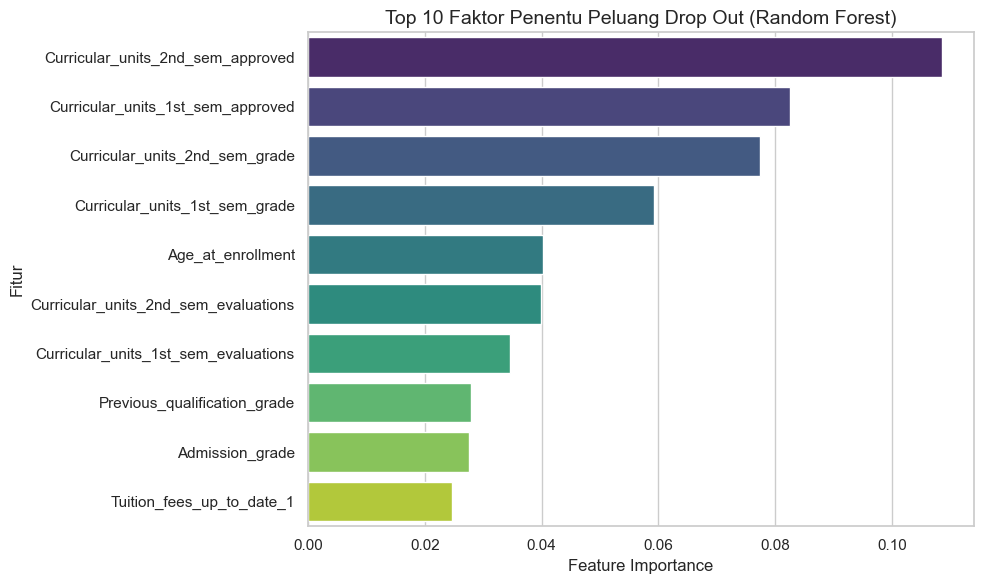

                                    Fitur  Importance
13      Curricular_units_2nd_sem_approved    0.108655
7       Curricular_units_1st_sem_approved    0.082540
14         Curricular_units_2nd_sem_grade    0.077443
8          Curricular_units_1st_sem_grade    0.059285
3                       Age_at_enrollment    0.040221
12   Curricular_units_2nd_sem_evaluations    0.039994
6    Curricular_units_1st_sem_evaluations    0.034538
1            Previous_qualification_grade    0.027922
2                         Admission_grade    0.027657
234             Tuition_fees_up_to_date_1    0.024658


In [20]:
import joblib
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Load model Random Forest yang sudah dilatih
rf = joblib.load("model_prediksi.pkl")

# Ambil nama fitur dari input_encoded (pastikan urutan sama dengan model)
feature_names = input_encoded.columns

# Ambil feature importances dari model
importances = rf.feature_importances_

# Buat DataFrame untuk visualisasi
feat_imp_df = (
    pd.DataFrame({"Fitur": feature_names, "Importance": importances})
    .sort_values("Importance", ascending=False)
)

# Plot 10 faktor teratas untuk peluang Drop Out
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(10), x="Importance", y="Fitur", palette="viridis")
plt.title("Top 10 Faktor Penentu Peluang Drop Out (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()

# Tampilkan tabel 10 fitur teratas
print(feat_imp_df.head(10))

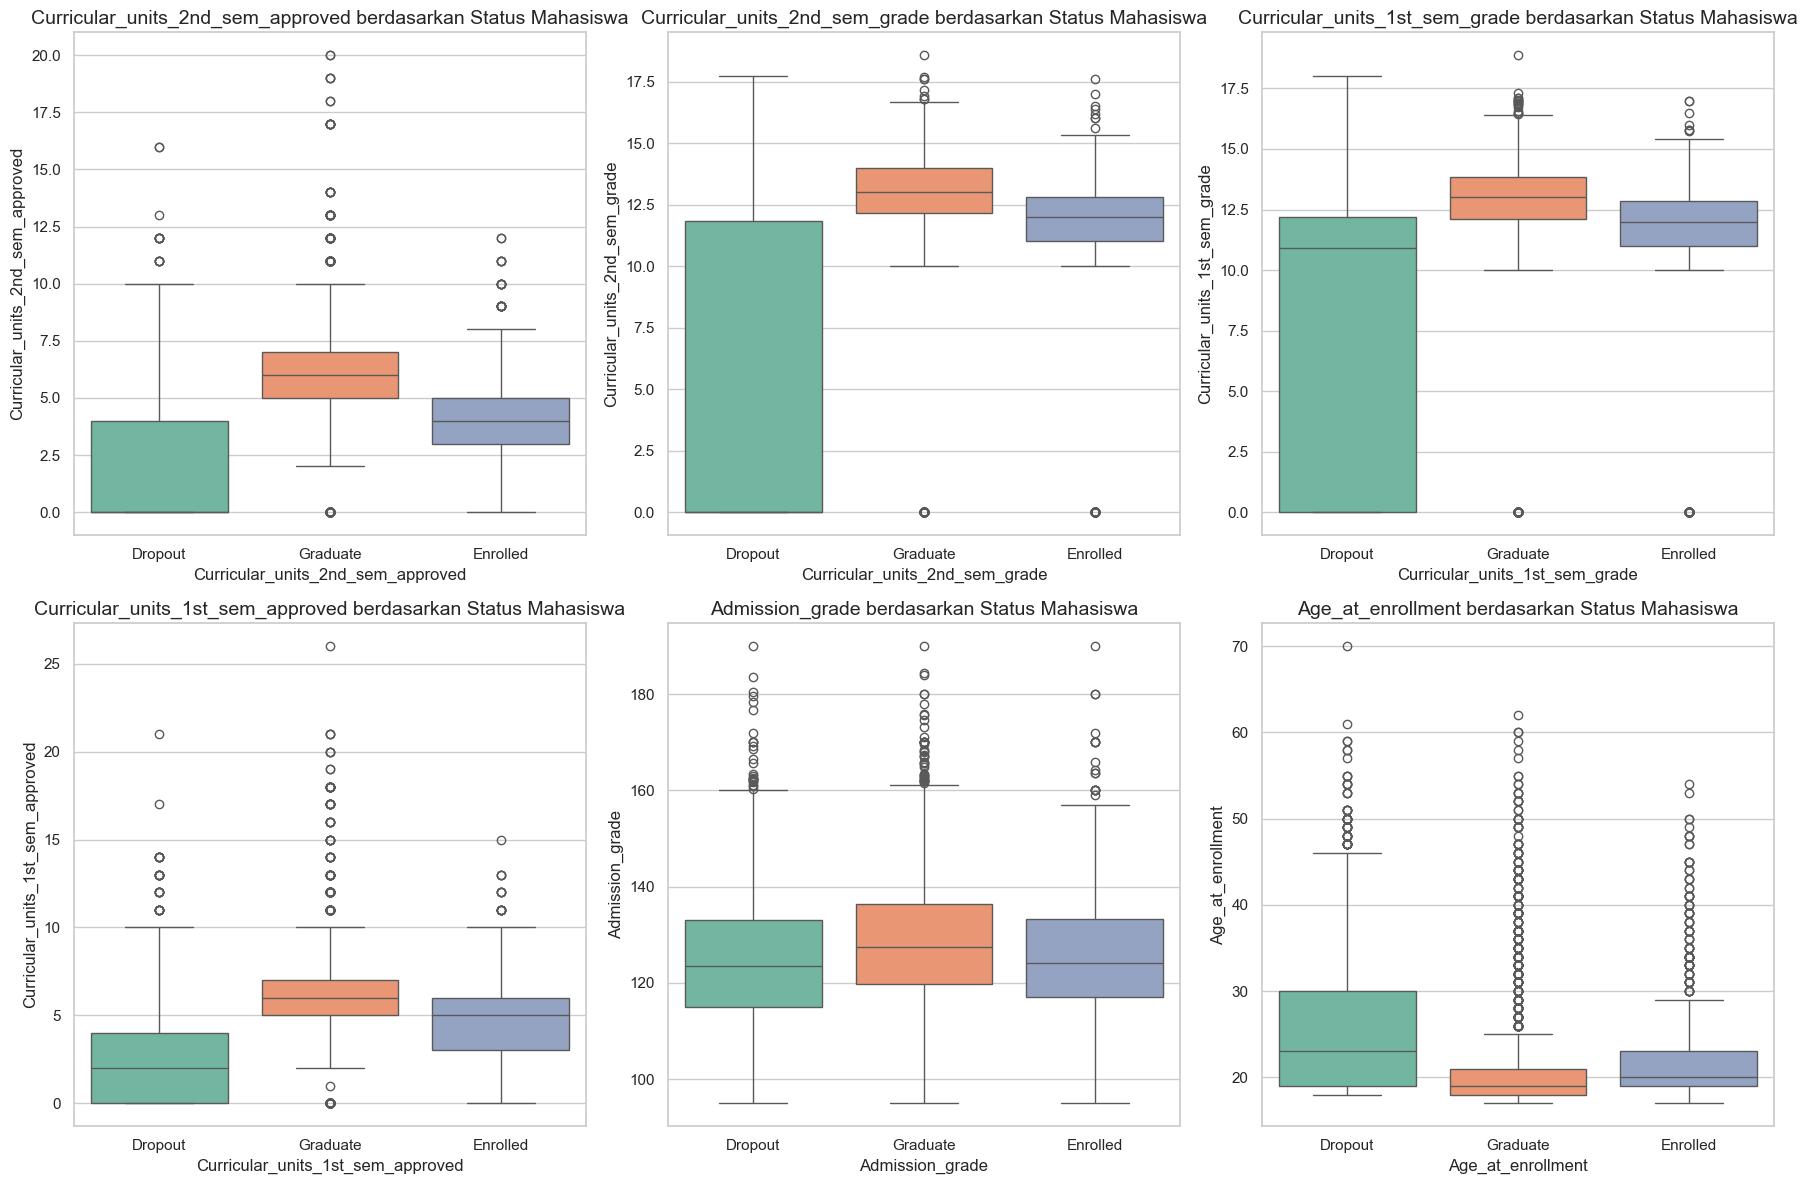


Distribusi 'Curricular_units_2nd_sem_approved' untuk masing-masing Status:
Status    Curricular_units_2nd_sem_approved
Dropout   0                                    727
          3                                    127
          5                                    119
          2                                    116
          4                                    112
          1                                     86
          6                                     64
          8                                     20
          7                                     19
          10                                    10
          12                                     7
          9                                      6
          11                                     5
          16                                     2
          13                                     1
Enrolled  4                                    160
          5                                    157
          3  

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load model Random Forest yang sudah dilatih
model = joblib.load("model_prediksi.pkl")

# Mapping label agar grafik mudah dipahami orang awam
status_map = {0: 'Tidak Drop out', 1: 'Drop Out'}
if 'Status' in dfc.columns:
    # Pastikan Status sudah dalam bentuk numerik (0/1) sesuai model
    dfc['StatusLabel'] = dfc['Status'].map(status_map).fillna(dfc['Status'])
else:
    dfc['StatusLabel'] = dfc['Status']

# Kolom yang akan divisualisasikan (fitur penting dari analisis sebelumnya)
cols = [
    'Curricular_units_2nd_sem_approved',
    'Curricular_units_2nd_sem_grade',
    'Curricular_units_1st_sem_grade',
    'Curricular_units_1st_sem_approved',
    'Admission_grade',
    'Age_at_enrollment',
]

plt.figure(figsize=(18, 12))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    if str(dfc[col].dtype) in ['float64', 'int64']:
        sns.boxplot(data=dfc, x='StatusLabel', y=col, palette='Set2')
        plt.ylabel(col)
    else:
        sns.countplot(data=dfc, x=col, hue='StatusLabel', palette='Set2')
        plt.ylabel('Jumlah')
    plt.title(f'{col} berdasarkan Status Mahasiswa')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Tampilkan angka jumlah masing-masing kategori pada fitur yang dipilih untuk setiap status
for col in cols:
    print(f"\nDistribusi '{col}' untuk masing-masing Status:")
    print(dfc.groupby('Status')[col].value_counts())


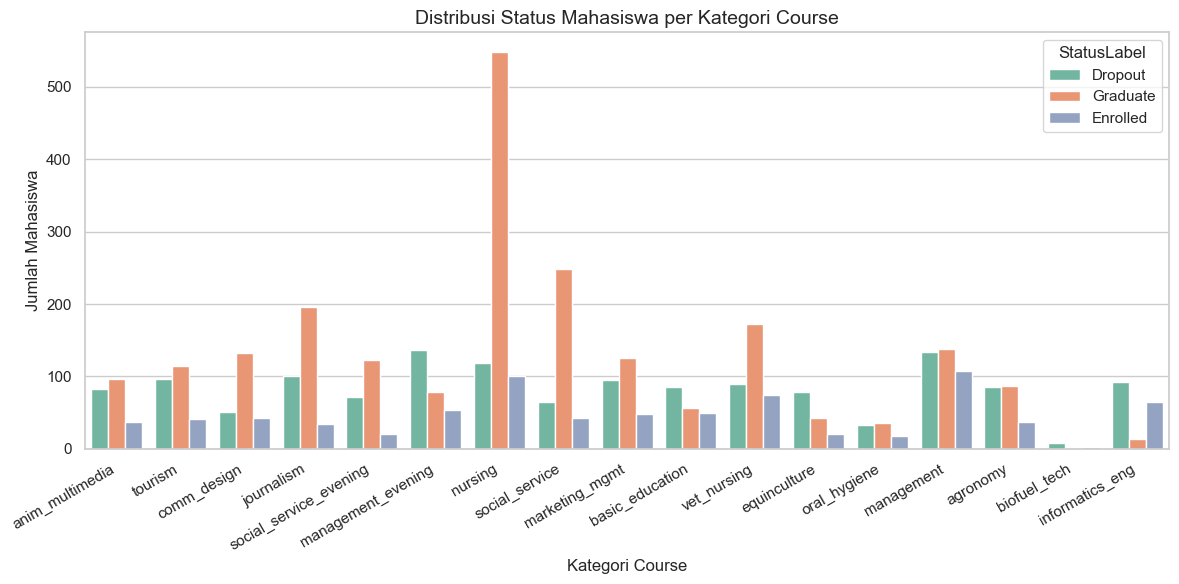


Distribusi 'Course' terhadap Status:
Status                  Dropout  Enrolled  Graduate
Course                                             
agronomy                     86        37        87
anim_multimedia              82        37        96
basic_education              85        50        57
biofuel_tech                  8         3         1
comm_design                  51        42       133
equinculture                 78        21        42
informatics_eng              92        64        14
journalism                  101        34       196
management                  134       108       138
management_evening          136        54        78
marketing_mgmt               95        48       125
nursing                     118       100       548
oral_hygiene                 33        17        36
social_service               65        42       248
social_service_evening       71        21       123
tourism                      96        41       115
vet_nursing               

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan kolom Course sudah terlabel (bukan kode angka)
plt.figure(figsize=(12, 6))
sns.countplot(data=dfc, x='Course', hue='StatusLabel', palette='Set2')
plt.title('Distribusi Status Mahasiswa per Kategori Course')
plt.xlabel('Kategori Course')
plt.ylabel('Jumlah Mahasiswa')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Tampilkan distribusi Course vs Status
print("\nDistribusi 'Course' terhadap Status:")
print(dfc.groupby(['Course', 'Status']).size().unstack(fill_value=0))

# Persentase dropout per kategori Course
print("\nPersentase Dropout per Kategori Course:")
course_dropout = (dfc[dfc['Status'] == 'Dropout'].groupby('Course').size() / dfc.groupby('Course').size()) * 100
print(course_dropout.round(2).astype(str) + " %")


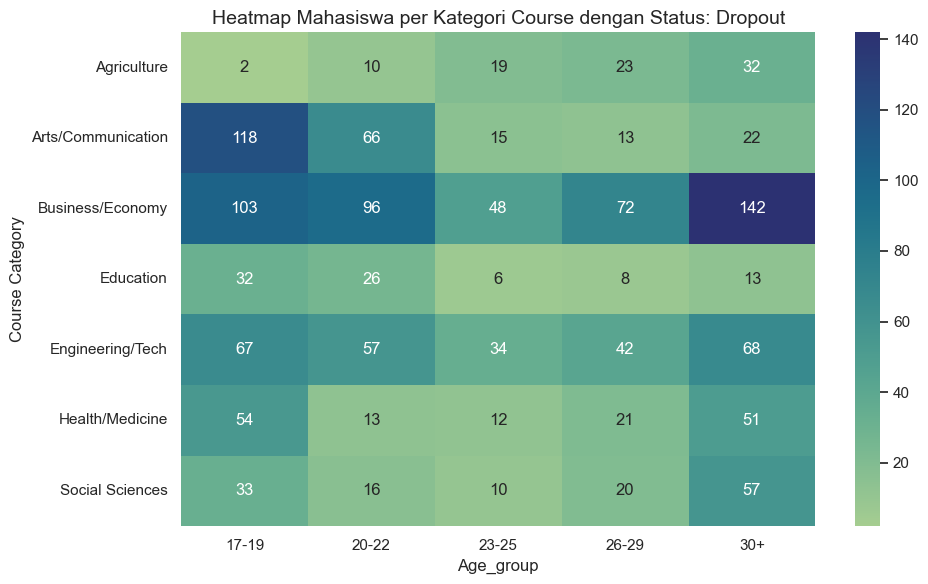

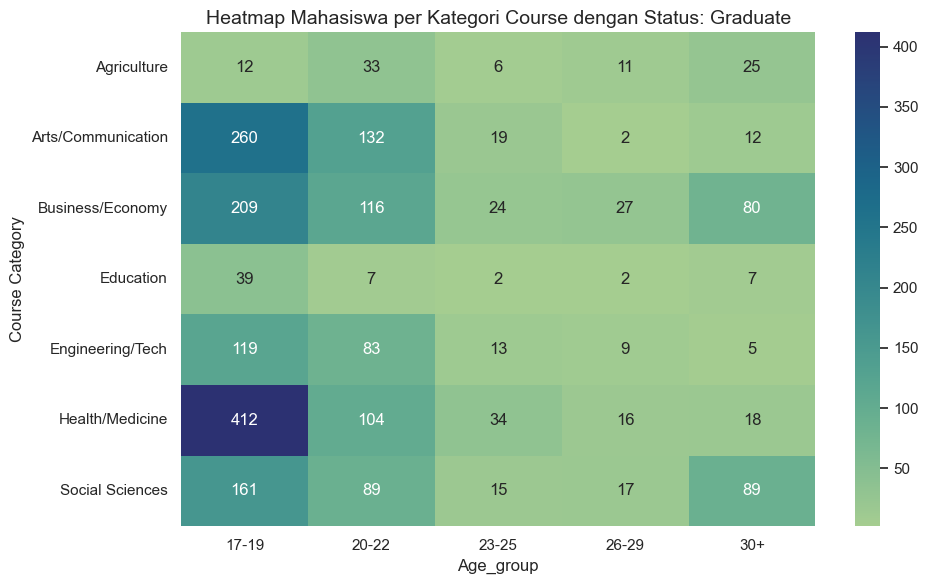

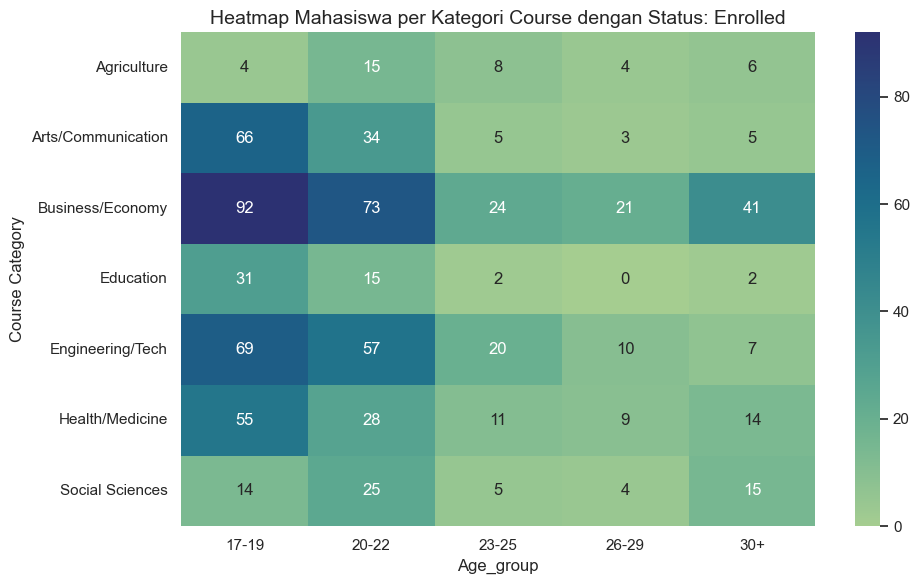

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset hasil labeling
df_labeled = pd.read_csv('cleaned_dataset_labeled.csv')

# Pastikan kolom yang diperlukan ada
if {'Course', 'Age_group', 'Status'}.issubset(df_labeled.columns):
    # Gunakan label status yang mudah dibaca jika sudah ada
    if 'StatusLabel' in df_labeled.columns:
        status_col = 'StatusLabel'
    else:
        status_col = 'Status'
    status_list = df_labeled[status_col].dropna().unique()
    course_categories = sorted(df_labeled['Course'].unique())

    for status in status_list:
        df_filtered = df_labeled[df_labeled[status_col] == status]
        heatmap_data = pd.crosstab(index=df_filtered['Course'], columns=df_filtered['Age_group'])
        heatmap_data = heatmap_data.reindex(course_categories, fill_value=0)

        plt.figure(figsize=(10, 6))
        sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='crest')
        plt.title(f'Heatmap Mahasiswa per Kategori Course dengan Status: {status}')
        plt.xlabel('Age_group')
        plt.ylabel('Course Category')
        plt.tight_layout()
        plt.show()
else:
    print("Kolom 'Course', 'Age_group', atau 'Status' tidak ditemukan di dataset.")


## Insight Heatmap: Drop Out Berdasarkan Course & Age Group
Heatmap ini menggambarkan jumlah mahasiswa yang drop out berdasarkan kategori kursus dan kelompok usia. Dengan melihat pola warna yang berubah dari hijau muda hingga biru tua, kita bisa menarik beberapa wawasan penting:

Distribusi Mahasiswa Berdasarkan Kategori Kursus & Kelompok Usia
- Health/Medicine memiliki jumlah mahasiswa tertinggi di usia 17-19, baik dalam kategori mahasiswa yang lulus maupun mereka yang masih aktif.
- Arts/Communication juga menarik banyak mahasiswa muda, terutama di usia 17-19, dengan angka lulusan yang cukup tinggi tetapi juga tingkat drop out yang lebih besar dibandingkan beberapa kategori lain.
- Business/Economy memiliki tren unik dengan lebih banyak mahasiswa usia 30+, tetapi juga mengalami tingkat drop out yang tinggi di kelompok usia ini.
- Engineering/Tech dan Social Sciences menunjukkan distribusi yang lebih merata di berbagai kelompok usia.

Tren Drop Out
- Business/Economy mencatat jumlah drop out tertinggi, terutama di usia 30+.
- Arts/Communication juga memiliki tingkat drop out yang tinggi, terutama di usia 17-19.
- Agriculture menjadi kategori dengan tingkat drop out terendah, tetapi juga memiliki jumlah mahasiswa yang lebih sedikit dibandingkan kategori lain.

Tren Kelulusan
- Health/Medicine memiliki angka kelulusan paling tinggi, terutama di usia 17-19, menunjukkan bahwa program ini menarik banyak mahasiswa muda dan memiliki tingkat penyelesaian studi yang kuat.
- Arts/Communication juga menunjukkan jumlah lulusan yang signifikan di usia muda.
- Kategori Business/Economy, Engineering/Tech, dan Social Sciences memiliki kelulusan yang lebih tersebar di berbagai kelompok usia.
Kesimpulan & Wawasan Strategis
- Bidang Health/Medicine menunjukkan daya tarik kuat bagi mahasiswa muda dan memiliki tingkat kelulusan tinggi, yang bisa mencerminkan program pendidikan yang lebih terstruktur atau sistem pembelajaran yang efektif.
- Business/Economy menarik lebih banyak mahasiswa yang lebih tua, tetapi tingkat drop out tinggi di kelompok ini mungkin menunjukkan tantangan dalam penyelesaian studi mereka.
- Arts/Communication memiliki angka drop out tinggi, tetapi juga tingkat kelulusan yang cukup besar. Ini bisa menunjukkan bahwa bidang ini menarik banyak mahasiswa tetapi memiliki tantangan dalam menyelesaikan studi.
- Agriculture memiliki jumlah mahasiswa rendah, tetapi tingkat drop out juga sedikit. Ini menunjukkan bahwa meskipun bidang ini tidak menarik banyak mahasiswa, mereka yang memilihnya cenderung lebih stabil dalam menyelesaikan studi.


**Korelasi heatmap dan feature importance:**
- Fitur akademik semester awal (approved, grade, evaluations) sangat menentukan, dan heatmap memperlihatkan jurusan dengan performa akademik rendah cenderung memiliki dropout lebih tinggi.
- Usia saat masuk kuliah (Age_at_enrollment) juga berpengaruh, terlihat pada distribusi usia di heatmap.
- Jurusan dengan banyak mahasiswa usia muda dan progres akademik baik cenderung memiliki dropout lebih rendah.


## Evaluasi Drop Out Berdasarkan Fitur

### Berdasarkan hasil model **Random Forest**, berikut adalah fitur-fitur dengan pengaruh terbesar terhadap keputusan mahasiswa Drop Out:

1. **Curricular_units_2nd_sem_approved** — Semakin banyak mata kuliah semester 2 yang disetujui, semakin kecil risiko Drop Out.
2. **Curricular_units_2nd_sem_grade** — Nilai akademik semester 2 sangat menentukan keberlanjutan studi.
3. **Curricular_units_1st_sem_grade** — Nilai semester 1 menjadi indikator awal risiko Drop Out.
4. **Curricular_units_1st_sem_approved** — Jumlah mata kuliah semester 1 yang disetujui juga sangat berpengaruh.
5. **Admission_grade** — Nilai masuk memberikan gambaran potensi akademik awal.
6. **Curricular_units_2nd_sem_evaluations** — Partisipasi dalam evaluasi semester 2 menurunkan risiko Drop Out.
7. **Previous_qualification_grade** — Nilai pendidikan sebelumnya berkontribusi pada keberhasilan studi.
8. **Age_at_enrollment** — Usia saat mendaftar memengaruhi risiko Drop Out.
9. **Tuition_fees_up_to_date** — Keteraturan pembayaran biaya kuliah menurunkan risiko Drop Out.
10. **Curricular_units_1st_sem_evaluations** — Partisipasi evaluasi semester 1 juga penting.

## Rekomendasi Action Items untuk Menurunkan Drop Out
Berikut adalah daftar tindakan strategis berbasis data yang dapat diimplementasikan oleh manajemen Jaya Jaya Institut untuk mengurangi tingkat Drop Out:

### Kesimpulan Evaluasi Model Prediksi Drop Out

Berdasarkan seluruh proses analisis data, pemodelan, dan evaluasi, berikut poin-poin utama yang dapat disimpulkan:

- **Model Random Forest dan XGBoost** memberikan performa terbaik dalam memprediksi risiko dropout mahasiswa, dengan akurasi dan F1-score tinggi, serta mampu membedakan kelas Drop Out dan Tidak Drop Out dengan baik.
- **Faktor akademik** seperti jumlah mata kuliah yang disetujui dan nilai pada semester 1 & 2 adalah penentu utama risiko dropout. Mahasiswa dengan progres akademik rendah di semester awal sangat rentan keluar.
- **Faktor keuangan** (keteraturan pembayaran biaya kuliah, status debitur) dan **penerima beasiswa** juga berpengaruh signifikan terhadap risiko dropout.
- **Usia saat masuk kuliah** dan **jurusan tertentu** (misal: Management, Informatics Engineering, Management Evening) memiliki tingkat dropout lebih tinggi, terutama pada kelompok usia muda.
- **Faktor demografi dan ekonomi makro** (seperti GDP, tingkat pengangguran) memiliki pengaruh lebih kecil dibanding faktor akademik dan keuangan individu.



1. **Intervensi Akademik Dini**
    - Monitoring progres akademik mahasiswa di semester 1 & 2 secara berkala.
    - Identifikasi mahasiswa dengan nilai rendah atau sedikit mata kuliah yang disetujui sejak awal.
    - Sediakan program remedial, bimbingan belajar, dan mentoring akademik.

2. **Dukungan Keuangan dan Konseling**
    - Identifikasi mahasiswa dengan status debitur atau keterlambatan pembayaran biaya kuliah.
    - Tawarkan solusi seperti keringanan, cicilan, atau beasiswa tambahan.
    - Perkuat layanan konseling keuangan dan sosialisasi program bantuan.

3. **Pendekatan Khusus untuk Jurusan dan Usia Risiko Tinggi**
    - Fokuskan program pencegahan dropout pada jurusan dan kelompok usia yang memiliki tingkat dropout tinggi.
    - Kembangkan program orientasi, adaptasi, dan penguatan soft skill untuk mahasiswa baru, terutama usia <23 tahun.
    - Tawarkan program orientasi dan adaptasi khusus untuk mahasiswa yang lebih tua atau berasal dari latar belakang pendidikan berbeda.
    - Sediakan layanan konseling dan career coaching.

4.  **Insight Usia & Jurusan**
    - Mahasiswa usia 17-19 tahun mendominasi Health/Medicine dan Arts/Communication, namun dropout di Arts/Communication lebih tinggi pada kelompok usia muda.
    - Business/Economy memiliki dropout tertinggi pada mahasiswa usia 30+, menandakan tantangan adaptasi atau beban eksternal pada mahasiswa dewasa.
    - Engineering/Tech dan Social Sciences relatif stabil di semua kelompok usia, namun tetap perlu perhatian pada kelompok usia muda yang baru beradaptasi dengan dunia kampus.

5.  **Action Item Spesifik berdasar Heatmap**
    - Mahasiswa Muda (17-19 tahun) di Arts/Communication: Perkuat orientasi, mentoring, pengembangan soft skill, dan konseling adaptasi sejak awal semester. Libatkan alumni/senior sebagai mentor.
    - Mahasiswa Usia 30+ di Business/Economy: Tawarkan fleksibilitas jadwal (kelas malam, blended learning), konseling karir, manajemen waktu, dan komunitas mahasiswa dewasa.
    - Semua Jurusan dengan Dropout Tinggi: Monitoring progres akademik lebih intensif pada semester awal, kolaborasi dengan dosen wali, program remedial, dan pelatihan belajar efektif.
    - Jurusan dengan Kelulusan Tinggi (Health/Medicine): Jadikan best practice—adopsi sistem pembelajaran, mentoring, dan monitoring yang terbukti efektif di jurusan ini untuk diterapkan di jurusan lain.

6. **Peningkatan Keterlibatan Akademik**
    - Dorong partisipasi aktif dalam evaluasi dan kegiatan akademik.
    - Sediakan workshop motivasi dan manajemen waktu.
    - Libatkan mahasiswa dalam komunitas akademik dan organisasi kampus.

7. **Peningkatan Sistem Monitoring dan Dashboard**
    - Implementasikan dashboard prediksi dropout berbasis data untuk memantau mahasiswa berisiko secara real-time.
    - Integrasikan model prediksi Drop Out ke dalam dashboard monitoring kampus.
    - Tampilkan metrik risiko Drop Out untuk tiap segmen mahasiswa.
    - Buat notifikasi dini untuk dosen wali atau bagian kemahasiswaan jika terdapat kenaikan risiko pada kelompok tertentu.
    - Libatkan dosen wali dan bagian kemahasiswaan dalam pemantauan dan tindak lanjut.

8. **Evaluasi dan Penyesuaian Kurikulum**
    - Tinjau kembali beban dan struktur kurikulum pada jurusan dengan dropout tinggi.
    - Sesuaikan metode pembelajaran agar lebih adaptif terhadap kebutuhan mahasiswa.

### Kesimpulan
Faktor-faktor akademik, keuangan, dan keterlibatan mahasiswa sangat berpengaruh terhadap risiko Drop Out. Intervensi yang tepat dan berbasis data akan membantu institusi menurunkan tingkat Drop Out dan meningkatkan keberhasilan studi mahasiswa.



### Terima kasih atas perhatiannya dan semoga proyek ini bermanfaat!

Kritik dan saran bisa disampaikan ke saya melalui : 

**Github:** [Profdara](https://github.com/Profdara)  
**LinkedIn:** [profdara](https://www.linkedin.com/in/profdara)
 